# 한강공원(여의도) 주차 혼잡도(여유,보통,혼잡,매우혼잡) 예측

---
## 사용 데이터
    서울시 한강공원 일별 데이터 사용(2020~2024)
    서울시 올림픽대로 교통량 데이터 사용(2020~2024)

In [65]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
han_River = pd.read_csv("../../Data/한강공원 주차장 일별 이용 현황.csv",encoding='euc-kr')

---
## 데이터 전처리

### 여의도 한강공원 데이터 추출

    주차장 별 주차구획수(계):
    여의도1주차장 - 462
    여의도2주차장 - 176
    여의도3주차장 - 785
    여의도4주차장 - 218
    여의도5주차장 - 141

In [66]:
# PLT-008(여의도 한강공원)
han_River = han_River[han_River['지구별'] == 'PLT-008'].sort_index(ignore_index=True)

### 데이터 구조 확인
    컬럼의 이름, 데이터 유형, 결측치 여부를 확인하여 데이터의 기본 구조를 파악

In [67]:
# 데이터 head
han_River.head()

지구별     주차장명  주차대수    이용시간          날짜
0  PLT-008  여의도5주차장   229   22509  2024/11/10
1  PLT-008  여의도2주차장  1934  150135  2024/11/10
2  PLT-008  여의도1주차장  3398  355119  2024/11/10
3  PLT-008  여의도4주차장    41    1994  2024/11/10
4  PLT-008  여의도3주차장  2326  318649  2024/11/10

In [68]:
# 데이터 tail
han_River.tail()

지구별     주차장명  주차대수    이용시간          날짜
8675  PLT-008  여의도1주차장  1541  172802  2020/01/18
8676  PLT-008  여의도1주차장  1113  255747  2020/01/17
8677  PLT-008  여의도1주차장   873  221484  2020/01/16
8678  PLT-008  여의도1주차장   114    6073  2020/01/15
8679  PLT-008  여의도1주차장     2       0  2020/01/14

In [69]:
# 데이터 정보 확인
han_River.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8680 entries, 0 to 8679
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   지구별     8680 non-null   object
 1   주차장명    8680 non-null   object
 2   주차대수    8680 non-null   int64 
 3   이용시간    8680 non-null   int64 
 4   날짜      8680 non-null   object
dtypes: int64(2), object(3)
memory usage: 339.2+ KB


> NaN값이 없는 것을 확인 할 수 있다.

In [70]:
# 기초 통계 확인
han_River.describe()

주차대수           이용시간
count  8680.000000    8680.000000
mean   1039.982488  171226.257143
std     996.637386  133462.043181
min       1.000000       0.000000
25%     255.000000   69112.000000
50%     821.500000  130141.000000
75%    1465.000000  270569.000000
max    7424.000000  646550.000000

> 주차장 주차구획수가 없으므로 컬럼 추가

In [71]:
# 주차장별 총 주차 가능 대수
total_parking_capacity = {
    '여의도1주차장': 462,
    '여의도2주차장': 176,
    '여의도3주차장': 785,
    '여의도4주차장': 218,
    '여의도5주차장': 141,
}

# '주차장명'을 기준으로 '주차구획수' 컬럼 추가
han_River['주차구획수'] = han_River['주차장명'].map(total_parking_capacity)

# 확인
han_River[['주차장명', '주차구획수']].head()

주차장명  주차구획수
0  여의도5주차장    141
1  여의도2주차장    176
2  여의도1주차장    462
3  여의도4주차장    218
4  여의도3주차장    785

### 휴일여부 및 요일 추가

In [72]:
han_River

지구별     주차장명  주차대수    이용시간          날짜  주차구획수
0     PLT-008  여의도5주차장   229   22509  2024/11/10    141
1     PLT-008  여의도2주차장  1934  150135  2024/11/10    176
2     PLT-008  여의도1주차장  3398  355119  2024/11/10    462
3     PLT-008  여의도4주차장    41    1994  2024/11/10    218
4     PLT-008  여의도3주차장  2326  318649  2024/11/10    785
...       ...      ...   ...     ...         ...    ...
8675  PLT-008  여의도1주차장  1541  172802  2020/01/18    462
8676  PLT-008  여의도1주차장  1113  255747  2020/01/17    462
8677  PLT-008  여의도1주차장   873  221484  2020/01/16    462
8678  PLT-008  여의도1주차장   114    6073  2020/01/15    462
8679  PLT-008  여의도1주차장     2       0  2020/01/14    462

[8680 rows x 6 columns]

In [73]:
# 날짜 컬럼을 날짜 형식으로 전환
han_River['날짜'] = pd.to_datetime(han_River['날짜'], format= '%Y/%m/%d')

# 월별로 차이를 알기 위해 연도,월,일별 컬럼 추가
han_River['연도'] = han_River['날짜'].dt.year
han_River['월'] = han_River['날짜'].dt.month
han_River['일'] = han_River['날짜'].dt.day

In [74]:
import holidays

# 대한민국 공휴일 불러오기
kr_holidays = holidays.KR(years=range(2020,2025))

# 요일 숫자를 요일 이름으로 변환
han_River['요일'] = han_River['날짜'].dt.weekday

# 공휴일 체크
han_River['휴일여부'] = han_River['날짜'].apply(lambda x: 2 if x in kr_holidays else (1 if x.weekday() >= 5 else 0))

# 데이터 확인
han_River

지구별     주차장명  주차대수    이용시간         날짜  주차구획수    연도   월   일  요일  휴일여부
0     PLT-008  여의도5주차장   229   22509 2024-11-10    141  2024  11  10   6     1
1     PLT-008  여의도2주차장  1934  150135 2024-11-10    176  2024  11  10   6     1
2     PLT-008  여의도1주차장  3398  355119 2024-11-10    462  2024  11  10   6     1
3     PLT-008  여의도4주차장    41    1994 2024-11-10    218  2024  11  10   6     1
4     PLT-008  여의도3주차장  2326  318649 2024-11-10    785  2024  11  10   6     1
...       ...      ...   ...     ...        ...    ...   ...  ..  ..  ..   ...
8675  PLT-008  여의도1주차장  1541  172802 2020-01-18    462  2020   1  18   5     1
8676  PLT-008  여의도1주차장  1113  255747 2020-01-17    462  2020   1  17   4     0
8677  PLT-008  여의도1주차장   873  221484 2020-01-16    462  2020   1  16   3     0
8678  PLT-008  여의도1주차장   114    6073 2020-01-15    462  2020   1  15   2     0
8679  PLT-008  여의도1주차장     2       0 2020-01-14    462  2020   1  14   1     0

[8680 rows x 11 columns]

### 평균 이용시간 추가

In [75]:
# 한글 폰트 문제 해결 
# matplotlib은 한글 폰트를 지원하지 않음
# os정보
import platform
import matplotlib.pyplot as plt

# font_manager : 폰트 관리 모듈
# rc : 폰트 변경 모듈
from matplotlib import font_manager, rc
# unicode 설정
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic') # os가 macos
elif platform.system() == 'Windows':
    path = 'c:/Windows/Fonts/malgun.ttf' # os가 windows
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print("Unknown System")

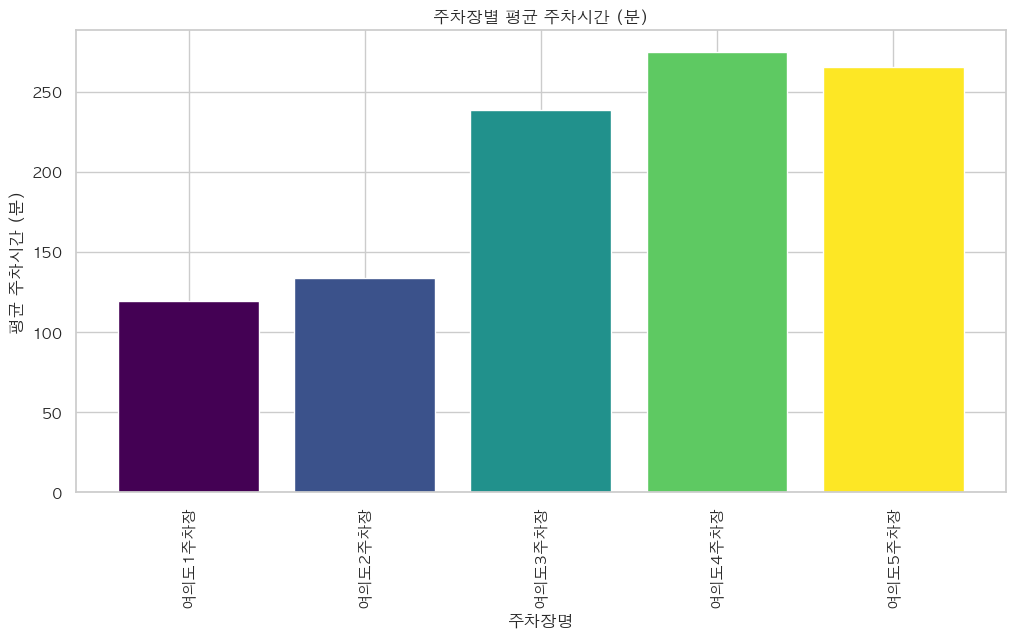

In [76]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# 주차장별 평균 주차시간을 계산
avg_parking_time = han_River.groupby('주차장명').apply(lambda x: x['이용시간'].sum() / x['주차대수'].sum())
avg_parking_time = avg_parking_time.reset_index()
avg_parking_time.columns = ['주차장명', '평균_주차시간(분)']

# 그래프 그리기
plt.figure(figsize=(12, 6))

# 컬러맵에서 색상 가져오기
colors = cm.get_cmap('viridis', len(avg_parking_time))

# 바 그래프 그리기 (각 바마다 다른 색상 적용)
bars = plt.bar(avg_parking_time['주차장명'], avg_parking_time['평균_주차시간(분)'], color=[colors(i) for i in range(len(avg_parking_time))])

plt.title('주차장별 평균 주차시간 (분)')
plt.xlabel('주차장명')
plt.ylabel('평균 주차시간 (분)')
plt.xticks(rotation=90)
plt.show()

> 

### 교통량 정보 불러오기

> 데이터가 일별 누적 주차대수밖에 없으므로 교통량을 불러와 일별 누적 추자대수를 교통량을 기준으로 시간대별로 나눠줘야함.        
2020년 01월 ~ 2024 09월 까지 데이터 수집

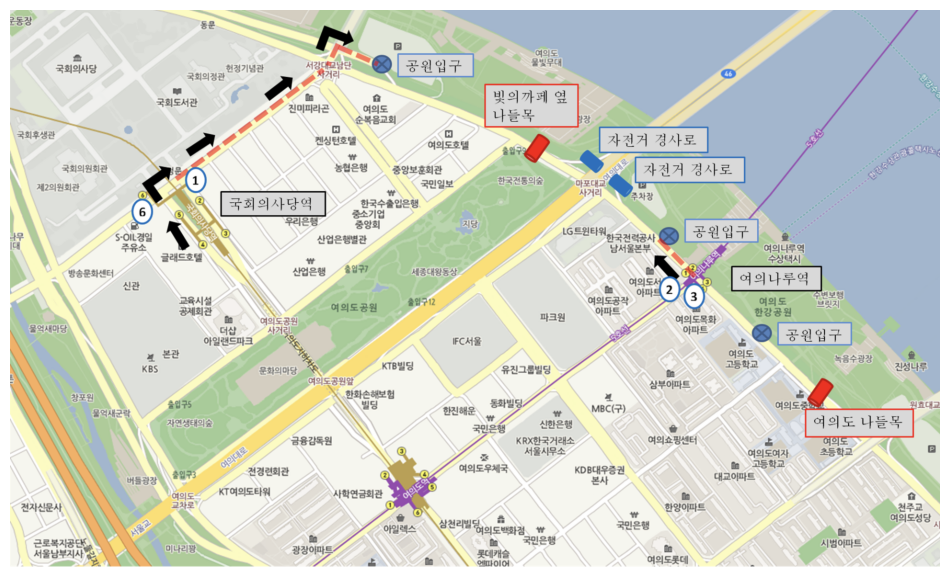

In [77]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 이미지 읽기
img = mpimg.imread('../../Data/올림픽대로 유입.png')

# 이미지 표시
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')  # 축 제거
plt.show()

### 올림픽대로와 한강공원의 유입/유출 관계
    유입:
    올림픽대로에서 여의도 한강공원으로 들어가는 차량의 경로를 "유입"으로 간주할 수 있습니다.
    지도에서 "공원입구"와 "자전거 경사로" 등으로 표기된 지점이 한강공원으로의 유입 지점으로 보입니다.

    유출:
    한강공원 주차장에서 나와 올림픽대로로 진입하는 차량은 "유출"에 해당합니다.
    여의도 한강공원에서 올림픽대로로의 나들목은 유출 경로로 작용합니다.

**따라서 한강공원의 주차대수를 예측하기 위해서 올림픽대로의 유입 교통량을 사용하여 예측하는 것이 바람직합니다.**

In [78]:
# import os
# import pandas as pd

# # 데이터가 저장된 최상위 폴더 경로
# base_folder = '../../Data/Traffic_volume'

# # 빈 리스트 생성
# dataframes = []

# # 폴더 내 모든 파일 탐색
# for root, dirs, files in os.walk(base_folder):
#     for file in files:
#         if file.endswith('.xlsx'):  # 엑셀 파일만 처리
#             file_path = os.path.join(root, file)
#             print(f"Processing file: {file_path}")  # 현재 처리 중인 파일 출력
            
#             # 엑셀 파일 읽기
#             try:
#                 df = pd.read_excel(file_path)
#             except Exception as e:
#                 print(f"Error reading {file_path}: {e}")
#                 continue
            
#             # 필요한 컬럼만 선택
#             if '지점명' in df.columns and '일자' in df.columns:
#                 traffic_columns = ['지점명', '일자', '방향'] + [f'{i}시' for i in range(24) if f'{i}시' in df.columns]
#                 df = df[traffic_columns]
                
#                 # "지점명"이 "올림픽대로"인 데이터만 필터링
#                 df_filtered = df[(df['지점명'] == '올림픽대로') & (df['방향'] == '유입')]
                
#                 if not df_filtered.empty:
#                     print(f"Rows added from {file_path}: {len(df_filtered)}")
#                     dataframes.append(df_filtered)
#             else:
#                 print(f"Missing key columns in {file_path}, skipping...")

# # 데이터프레임 병합
# if dataframes:
#     combined_df = pd.concat(dataframes, ignore_index=True)
#     combined_df.to_csv('./올림픽대로 교통량.csv', index=False)
#     print("Combined data saved to './올림픽대로 교통량.csv'")
# else:
#     print("No data to combine. Exiting...")


In [79]:
traffic = pd.read_csv('../../Data/Traffic_volume/올림픽대로 교통량.csv').sort_values(by='일자', ascending=True).reset_index(drop=True)
traffic

지점명        일자  방향      0시      1시      2시      3시      4시      5시  \
0     올림픽대로  20200101  유입  4102.0  4841.0  2986.0  2096.0  2099.0  2435.0   
1     올림픽대로  20200102  유입  2048.0  1254.0  1097.0  1069.0  1631.0  3393.0   
2     올림픽대로  20200103  유입  2778.0  2731.0  2072.0  1726.0  2129.0  3420.0   
3     올림픽대로  20200104  유입  4451.0  3548.0  2800.0  2323.0  2514.0  3204.0   
4     올림픽대로  20200105  유입  3409.0  2542.0  1902.0  1588.0  1817.0  2114.0   
...     ...       ...  ..     ...     ...     ...     ...     ...     ...   
1730  올림픽대로  20240926  유입  4105.0  2755.0  2094.0  1839.0  2554.0  4467.0   
1731  올림픽대로  20240927  유입  4677.0  3125.0  2376.0  2047.0  2619.0  4460.0   
1732  올림픽대로  20240928  유입  5985.0  3844.0  2779.0  2406.0  2881.0  4017.0   
1733  올림픽대로  20240929  유입  3962.0  2778.0  2157.0  1732.0  2121.0  2970.0   
1734  올림픽대로  20240930  유입  2953.0  1965.0  1626.0  1533.0  2292.0  4564.0   

          6시  ...     14시     15시     16시     17시     18시     19시     20시  \
0     2601.0  ...  6890.0  6973.0  7106.0  6215.0  5520.0  5298.0  5637.0   
1     6460.0  ...  7586.0  7710.0  7830.0  7787.0  6200.0  6087.0  6299.0   
2     5990.0  ...  7886.0  7309.0  7851.0  7656.0  6476.0  6195.0  6440.0   
3     4233.0  ...  7736.0  7412.0  7567.0  7203.0  6876.0  6206.0  5876.0   
4     2766.0  ...  7569.0  7469.0  7694.0  7133.0  6519.0  5750.0  5900.0   
...      ...  ...     ...     ...     ...     ...     ...     ...     ...   
1730  6829.0  ...  7134.0  6465.0  6443.0  5898.0  5853.0  6199.0  7014.0   
1731  6885.0  ...  6797.0  6826.0  6391.0  5852.0  5191.0  5957.0  6743.0   
1732  5208.0  ...  6110.0  6258.0  6139.0  6047.0  6076.0  6408.0  6103.0   
1733  4098.0  ...  6355.0  6546.0  6294.0  6499.0  5854.0  6070.0  5956.0   
1734  7163.0  ...  6902.0  6678.0  6177.0  6104.0  5616.0  5787.0  6726.0   

         21시     22시     23시  
0     5364.0  4567.0  2921.0  
1     6175.0  5935.0  4738.0  
2     7089.0  6635.0  5552.0  
3     6065.0  5663.0  4446.0  
4     5727.0  4965.0  3347.0  
...      ...     ...     ...  
1730  6589.0  6959.0  5740.0  
1731  6594.0  6506.0  6686.0  
1732  6180.0  6314.0  5197.0  
1733  6805.0  6200.0  3984.0  
1734  6853.0  6722.0  5614.0  

[1735 rows x 27 columns]

> 한강 데이터의 날짜가 Date type이므로 일자 type변경

In [80]:
traffic['일자'] = pd.to_datetime(traffic['일자'], format='%Y%m%d')

In [81]:
# 한강 데이터와 일자 맞추기
# 2020년 1월 14일부터 2024년 9월 30일까지의 데이터 추출 

# 시작일
start_date = '2020-01-14'
# 종료일
end_date = '2024-9-30'

# 날짜 추출
traffic = traffic[traffic['일자'].between(start_date, end_date)]
han_River = han_River[han_River['날짜'].between(start_date, end_date)]

# 결과확인
print(traffic.head())
print('*' * 100, '\n')
print(han_River.head())

      지점명         일자  방향      0시      1시      2시      3시      4시      5시  \
13  올림픽대로 2020-01-14  유입  3612.0  2586.0  1914.0  1737.0  1923.0  3425.0   
14  올림픽대로 2020-01-15  유입  3913.0  2778.0  2062.0  1756.0  2093.0  3524.0   
15  올림픽대로 2020-01-16  유입  4120.0  2924.0  2182.0  1885.0  2011.0  3507.0   
16  올림픽대로 2020-01-17  유입  4324.0  3048.0  2287.0  1953.0  2199.0  3592.0   
17  올림픽대로 2020-01-18  유입  5216.0  3847.0  3240.0  2455.0  2566.0  3431.0   

        6시  ...     14시     15시     16시     17시     18시     19시     20시  \
13  6221.0  ...  8041.0  7616.0  7835.0  7725.0  7090.0  6607.0  6165.0   
14  6084.0  ...  7027.0  7826.0  7584.0  7487.0  6584.0  6429.0  6447.0   
15  6328.0  ...  7443.0  7749.0  7836.0  7395.0  6690.0  6634.0  6372.0   
16  6208.0  ...  7265.0  7538.0  7954.0  7527.0  6499.0  6383.0  6505.0   
17  4389.0  ...  7657.0  7512.0  7202.0  7366.0  7308.0  7054.0  6143.0   

       21시     22시     23시  
13  6970.0  6717.0  5277.0  
14  6602.0  6688.0  5318.0  
15  7

In [82]:
# 모든 방향은 유입이므로 컬럼 삭제 
traffic.drop(columns='방향', inplace=True)

In [83]:
# 일자 => 날짜, 지점명 => 도로명
traffic.rename(columns={'지점명': '도로명','일자': '날짜'}, inplace=True)

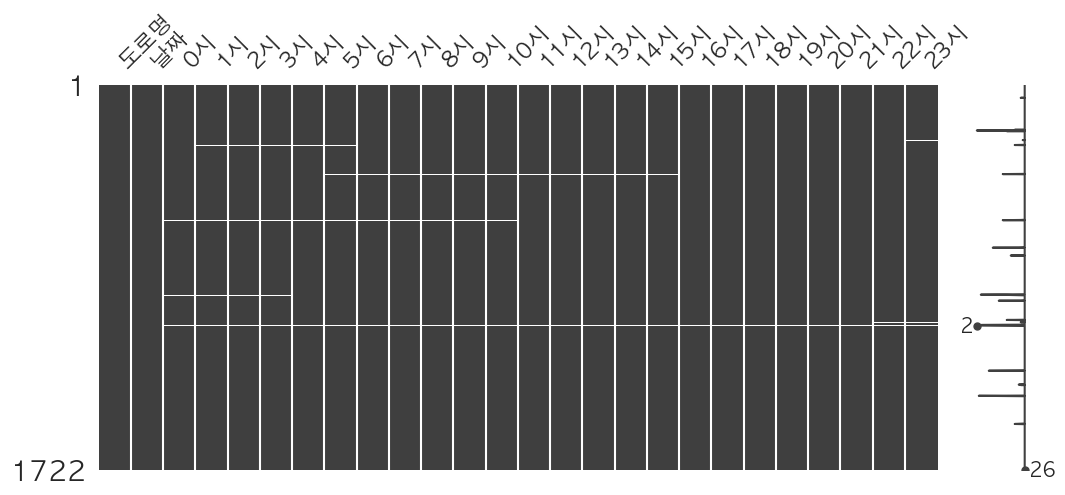

In [84]:
# 결측치 확인
import missingno as msno 

msno.matrix(traffic, figsize=(12, 5))
plt.show()

> 결측치가 존재하는 것을 확인 알 수 있다.           
하지만 결측치의 개수가 많지 않으므로 같은 요일을 기준으로 $NaN$값을 요일별 **평균대치법**을 이용해 처리.

In [85]:
# 한강 데이터와 교통량 데이터 merge
df = pd.merge(han_River, traffic, how='left')

In [86]:
# 요일별 평균으로 NaN 값 채우기
columns_with_nan = ['0시', '1시', '2시', '3시', '4시', '5시', '6시', '7시', '8시', '9시',
                    '10시', '11시', '12시', '13시', '14시', '15시', '16시', '17시', '18시',
                    '19시', '20시', '21시', '22시', '23시']

# 각 요일별 평균 계산 후 NaN 값 채우기
for col in columns_with_nan:
    df[col] = df.groupby('요일')[col].transform(lambda x: x.fillna(x.mean()))

# NaN 처리 결과 확인
print(df[columns_with_nan].isnull().sum())

0시     0
1시     0
2시     0
3시     0
4시     0
5시     0
6시     0
7시     0
8시     0
9시     0
10시    0
11시    0
12시    0
13시    0
14시    0
15시    0
16시    0
17시    0
18시    0
19시    0
20시    0
21시    0
22시    0
23시    0
dtype: int64


In [87]:
# 중간 저장
df.to_csv('../../Data/서울시 한강공원 주차대수 예측.csv')

### 교통량을 이용한 누적주차대수 분배

In [88]:
df['교통량 합계'] = df[
                   [
                   '6시', '7시', '8시', '9시', '10시', 
                   '11시', '12시', '13시', '14시', '15시', '16시', '17시',
                   '18시','19시', '20시', '21시', '22시', '23시', '0시'
                   ]
                   ].sum(axis=1)

### 주차대수 분배
    각 시간대 비율을 활용해 주차대수를 분배
$시간대별 주차대수 = 전체 주차대수 * 시간대비율$

In [89]:
# 아침, 낮, 저녁 시간대 열 정의
morning_columns = ['6시','7시','8시','9시','10시'] # 아침
afternoon_columns = ['11시','12시','13시','14시','15시','16시','17시'] # 낮
evening_columns = ['18시', '19시', '20시', '21시', '22시','23시','0시'] # 저녁

# 시간대별 교통량 합계 계산
df['아침 교통량 합계'] = df[morning_columns].sum(axis=1)
df['낮 교통량 합계'] = df[afternoon_columns].sum(axis=1)
df['저녁 교통량 합계'] = df[evening_columns].sum(axis=1)

# 시간대별 교통량 비율 계산
df['아침 교통량 비율'] = df['아침 교통량 합계'] / df['교통량 합계']
df['낮 교통량 비율'] = df['낮 교통량 합계'] / df['교통량 합계']
df['저녁 교통량 비율'] = df['저녁 교통량 합계'] / df['교통량 합계']

# 주차대수 분배
df['아침 주차대수'] = round(df['주차대수'] * df['아침 교통량 비율'],2)
df['낮 주차대수'] = round(df['주차대수'] * df['낮 교통량 비율'],2)
df['저녁 주차대수'] = round(df['주차대수'] * df['저녁 교통량 비율'],2)

In [90]:
df[[
                   '6시', '7시', '8시', '9시', '10시', 
                   '11시', '12시', '13시', '14시', '15시', '16시', '17시',
                   '18시','19시', '20시', '21시', '22시', '23시', '0시'
                   ]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8475 entries, 0 to 8474
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   6시      8475 non-null   float64
 1   7시      8475 non-null   float64
 2   8시      8475 non-null   float64
 3   9시      8475 non-null   float64
 4   10시     8475 non-null   float64
 5   11시     8475 non-null   float64
 6   12시     8475 non-null   float64
 7   13시     8475 non-null   float64
 8   14시     8475 non-null   float64
 9   15시     8475 non-null   float64
 10  16시     8475 non-null   float64
 11  17시     8475 non-null   float64
 12  18시     8475 non-null   float64
 13  19시     8475 non-null   float64
 14  20시     8475 non-null   float64
 15  21시     8475 non-null   float64
 16  22시     8475 non-null   float64
 17  23시     8475 non-null   float64
 18  0시      8475 non-null   float64
dtypes: float64(19)
memory usage: 1.2 MB


### 이용시간(누적) => 시간대별 이용시간

In [91]:
# 전체 주차대수 합계 계산 (아침, 낮, 저녁)
df['전체 시간대 주차대수'] = df['아침 주차대수'] + df['낮 주차대수'] + df['저녁 주차대수']

# 시간대별 주차대수 비율 계산
df['아침 비율'] = df['아침 주차대수'] / df['전체 시간대 주차대수']
df['낮 비율'] = df['낮 주차대수'] / df['전체 시간대 주차대수']
df['저녁 비율'] = df['저녁 주차대수'] / df['전체 시간대 주차대수']

# 시간대별 이용시간 계산
df['아침 이용시간'] = df['이용시간'] * df['아침 비율']
df['낮 이용시간'] = df['이용시간'] * df['낮 비율']
df['저녁 이용시간'] = df['이용시간'] * df['저녁 비율']

# 결과 확인
df[['날짜', '주차장명', '이용시간', '아침 이용시간', '낮 이용시간', '저녁 이용시간']].head()

날짜     주차장명    이용시간        아침 이용시간         낮 이용시간        저녁 이용시간
0 2024-09-30  여의도3주차장  407428  119921.907728  151763.007394  135743.084878
1 2024-09-30  여의도5주차장  102587   30193.775915   38212.977215   34180.246870
2 2024-09-30  여의도2주차장  201372   59270.689341   75010.012818   67091.297841
3 2024-09-30  여의도1주차장  450979  132739.981361  167986.340760  150252.677879
4 2024-09-30  여의도4주차장   69947   20587.848522   26056.118916   23303.032562

In [92]:
df.drop(columns=['전체 시간대 주차대수', '아침 비율', '낮 비율','저녁 비율'], inplace=True)

In [93]:
df.columns

Index(['지구별', '주차장명', '주차대수', '이용시간', '날짜', '주차구획수', '연도', '월', '일', '요일',
       '휴일여부', '도로명', '0시', '1시', '2시', '3시', '4시', '5시', '6시', '7시', '8시',
       '9시', '10시', '11시', '12시', '13시', '14시', '15시', '16시', '17시', '18시',
       '19시', '20시', '21시', '22시', '23시', '교통량 합계', '아침 교통량 합계', '낮 교통량 합계',
       '저녁 교통량 합계', '아침 교통량 비율', '낮 교통량 비율', '저녁 교통량 비율', '아침 주차대수', '낮 주차대수',
       '저녁 주차대수', '아침 이용시간', '낮 이용시간', '저녁 이용시간'],
      dtype='object')

> 이제 교통량에 대한 정보는 필요없으므로 삭제해줌  =>  다중공선성 방지

In [94]:
# 제거할 컬럼
columns_to_drop = ['0시','1시', '2시', '3시', '4시', '5시', '6시', '7시', '8시', '9시',
                   '10시', '11시', '12시', '13시', '14시', '15시', '16시', '17시',
                   '18시', '19시', '20시', '21시', '22시','23시',
                   '교통량 합계', '아침 교통량 합계', '낮 교통량 합계', '저녁 교통량 합계', '도로명',
                   '아침 교통량 비율', '낮 교통량 비율', '저녁 교통량 비율']

# 컬럼 제거
df.drop(columns=columns_to_drop, inplace=True)

# 결과 확인
df.head()

지구별     주차장명  주차대수    이용시간         날짜  주차구획수    연도  월   일  요일  휴일여부  \
0  PLT-008  여의도3주차장  1558  407428 2024-09-30    785  2024  9  30   0     0   
1  PLT-008  여의도5주차장   377  102587 2024-09-30    141  2024  9  30   0     0   
2  PLT-008  여의도2주차장  2381  201372 2024-09-30    176  2024  9  30   0     0   
3  PLT-008  여의도1주차장  3041  450979 2024-09-30    462  2024  9  30   0     0   
4  PLT-008  여의도4주차장   203   69947 2024-09-30    218  2024  9  30   0     0   

   아침 주차대수   낮 주차대수  저녁 주차대수        아침 이용시간         낮 이용시간        저녁 이용시간  
0   458.58   580.34   519.08  119921.907728  151763.007394  135743.084878  
1   110.96   140.43   125.61   30193.775915   38212.977215   34180.246870  
2   700.81   886.91   793.28   59270.689341   75010.012818   67091.297841  
3   895.08  1132.75  1013.17  132739.981361  167986.340760  150252.677879  
4    59.75    75.62    67.63   20587.848522   26056.118916   23303.032562

In [95]:
# 저장
df.to_csv('../../Data/서울시 한강공원 시간별 주차대수.csv')

---

## 상관관계

In [97]:
# 데이터 확인
df

지구별     주차장명  주차대수    이용시간         날짜  주차구획수    연도  월   일  요일  휴일여부  \
0     PLT-008  여의도3주차장  1558  407428 2024-09-30    785  2024  9  30   0     0   
1     PLT-008  여의도5주차장   377  102587 2024-09-30    141  2024  9  30   0     0   
2     PLT-008  여의도2주차장  2381  201372 2024-09-30    176  2024  9  30   0     0   
3     PLT-008  여의도1주차장  3041  450979 2024-09-30    462  2024  9  30   0     0   
4     PLT-008  여의도4주차장   203   69947 2024-09-30    218  2024  9  30   0     0   
...       ...      ...   ...     ...        ...    ...   ... ..  ..  ..   ...   
8470  PLT-008  여의도1주차장  1541  172802 2020-01-18    462  2020  1  18   5     1   
8471  PLT-008  여의도1주차장  1113  255747 2020-01-17    462  2020  1  17   4     0   
8472  PLT-008  여의도1주차장   873  221484 2020-01-16    462  2020  1  16   3     0   
8473  PLT-008  여의도1주차장   114    6073 2020-01-15    462  2020  1  15   2     0   
8474  PLT-008  여의도1주차장     2       0 2020-01-14    462  2020  1  14   1     0   

      아침 주차대수   낮 주차대수  저녁 주차대수        아침 이용시간         낮 이용시간        저녁 이용시간  
0      458.58   580.34   519.08  119921.907728  151763.007394  135743.084878  
1      110.96   140.43   125.61   30193.775915   38212.977215   34180.246870  
2      700.81   886.91   793.28   59270.689341   75010.012818   67091.297841  
3      895.08  1132.75  1013.17  132739.981361  167986.340760  150252.677879  
4       59.75    75.62    67.63   20587.848522   26056.118916   23303.032562  
...       ...      ...      ...            ...            ...            ...  
8470   354.57   654.68   531.75   39760.159079   73413.376613   59628.464309  
8471   299.44   441.87   371.69   68805.823612  101533.627035   85407.549353  
8472   238.22   348.38   286.41   60436.785925   88384.549914   72662.664162  
8473    30.55    46.38    37.07    1627.457456    2470.752105    1974.790439  
8474     0.53     0.82     0.65       0.000000       0.000000       0.000000  

[8475 rows x 17 columns]

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# import Packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 필수 라이브러리 설정
sns.set(style="whitegrid")
plt.rcParams['axes.labelsize'] = 12

In [ ]:
# 한글 폰트 문제 해결 
# matplotlib은 한글 폰트를 지원하지 않음
# os정보
import platform
import matplotlib.pyplot as plt

# font_manager : 폰트 관리 모듈
# rc : 폰트 변경 모듈
from matplotlib import font_manager, rc
# unicode 설정
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic') # os가 macos
elif platform.system() == 'Windows':
    path = 'c:/Windows/Fonts/malgun.ttf' # os가 windows
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print("Unknown System")

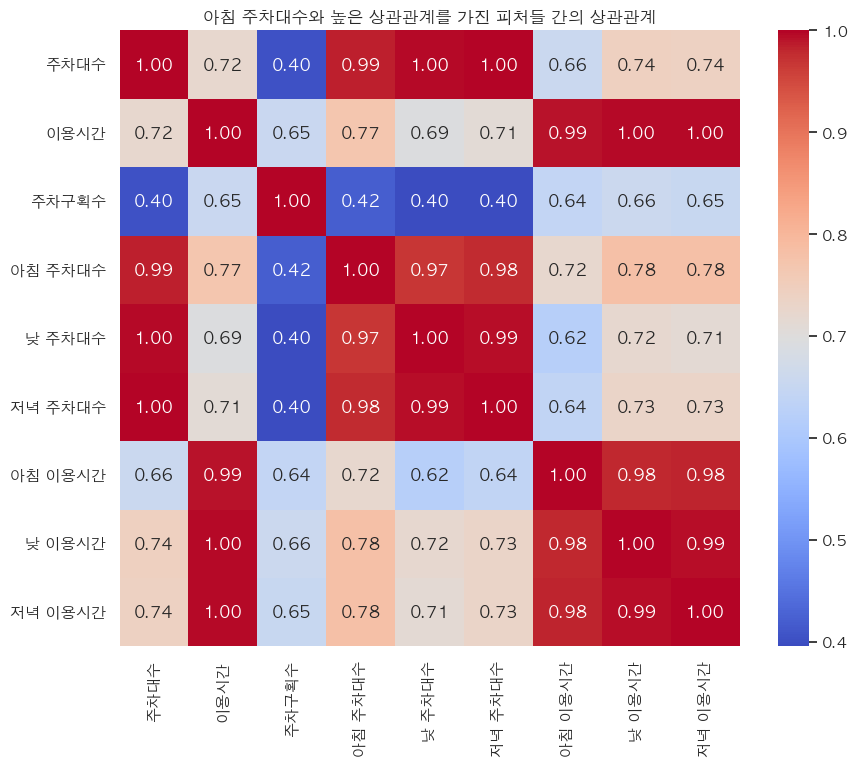

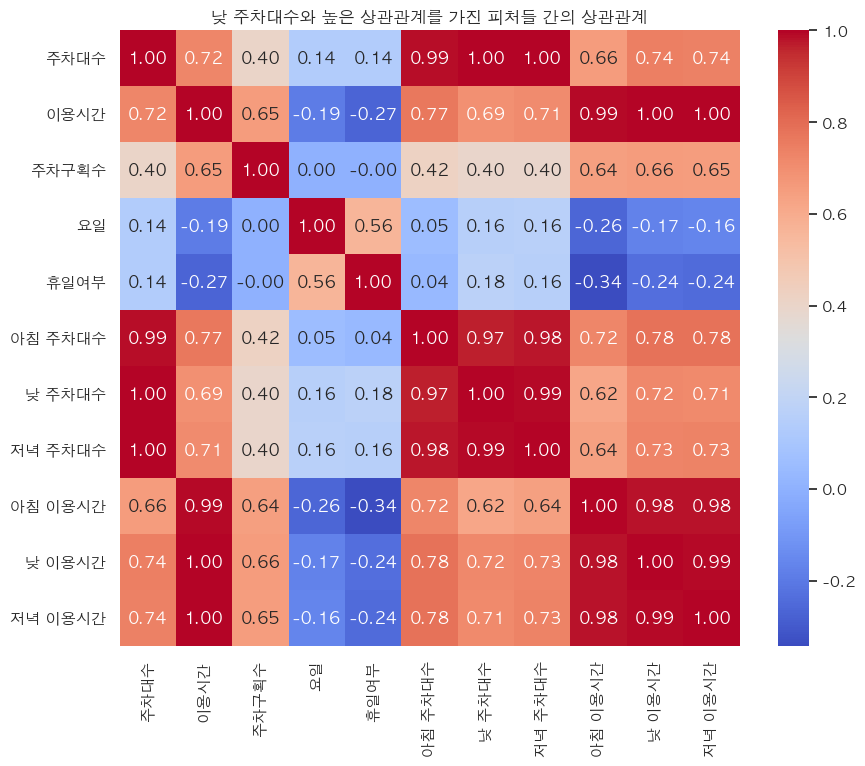

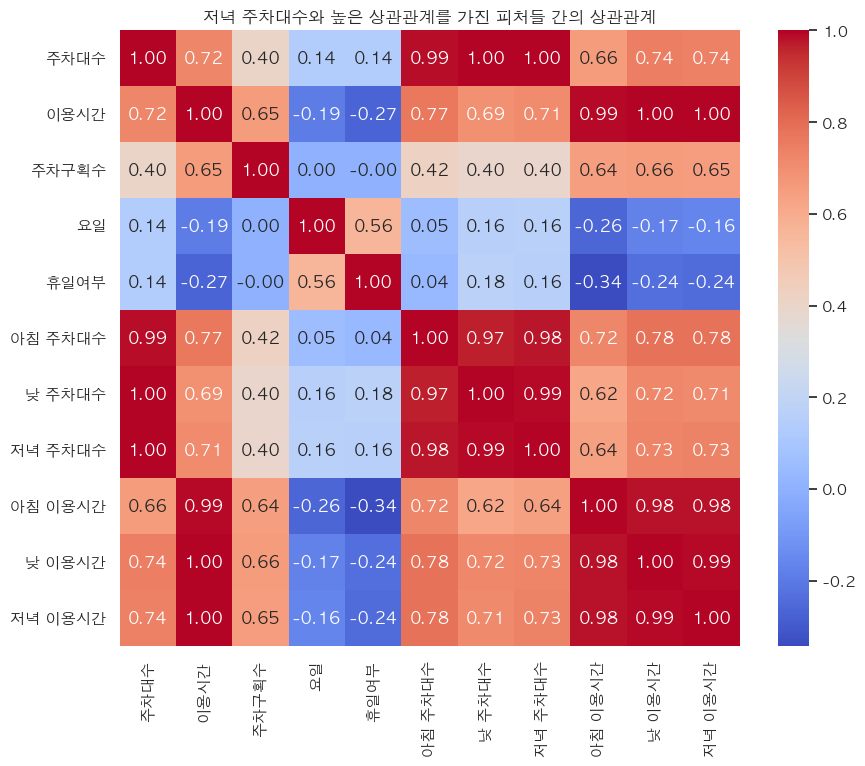

In [ ]:
# 숫자형 데이터만 선택
numeric_df = df.select_dtypes(include=['number'])

# 타겟 변수
targets = ['아침 주차대수', '낮 주차대수', '저녁 주차대수']

# 상관관계 계산 및 시각화
for target in targets:
    # 타겟 변수와의 상관관계 계산
    target_corr = numeric_df.corr()[target]

    # 절대값이 0.1 이상인 피처들만 선택
    high_corr_features = target_corr[abs(target_corr) >= 0.1].index
    
    # 상관관계 히트맵 그리기
    plt.figure(figsize=(10, 8))
    sns.heatmap(numeric_df[high_corr_features].corr(), annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
    plt.title(f'{target}와 높은 상관관계를 가진 피처들 간의 상관관계')
    plt.show()

### 아침, 낮, 저녁 주차대수와 관련 변수 
1. 아침 주차대수            
- 주차대수, 이용시간과 높은 상관관계를 가짐         
- 주차구획수는 상대적으로 낮은 상관관계를 가짐          
**아침 주차대수는 전체 주차대수와 밀접한 관련이 있으며, 이용시간 역시 중요한 영향을 미치는 변수로 확인됨.**         

2. 낮 주차대수          
- 주차대수, 이용시간과 높은 상관관계를 가짐         
- 요일, 휴일여부와는 약한 상관성을 나타냄.          
**낮 시간대 주차대수는 다른 시간대(아침,저녁)와 밀접하게 연계되어 있으며, 이용시간이 주차량 예측에 중요한 변수로 작용.**            

3. 저녁 주차대수            
= 주차대수, 아침 주차대수, **낮 주차대수**와 유사하게 높은 상관관계를 가짐.         
- 이용시간과의 상관관계도 상당히 높음(0.71).                
- 요일(0.16), 휴일여부(0.16)와는 상대적으로 낮은 상관관계를 가짐.           
**저녁 주차대수는 시간대별 주차대수(아침, 낮)와 밀접하게 연결되어 있으며, 주차 특성이 시간대에 걸쳐 연속적으로 유지되는 경향이 있음.**          

4. 결론         
**시간대별 주차대수는 전체 주차대수와 이용시간과 강한 상관관계를 가지며, 이는 시간대별 주차 특성이 주차량 예측에 중요한 역할을 함.**                            
**요일 및 휴일여부는 시간대별 주차대수와 약한 상관관계를 가지지만, 주차 패턴 변화에 유의미한 영향을 미칠 가능성이 있으므로 보조 변수로 고려할 수 있음.**          

이용시간은 사용자가 입력할 수 없으므로 이용시간 예측 모델을 생성하는 것도 고려해 보아야할 것 같음.

### 시간대별 이용시간의 분포

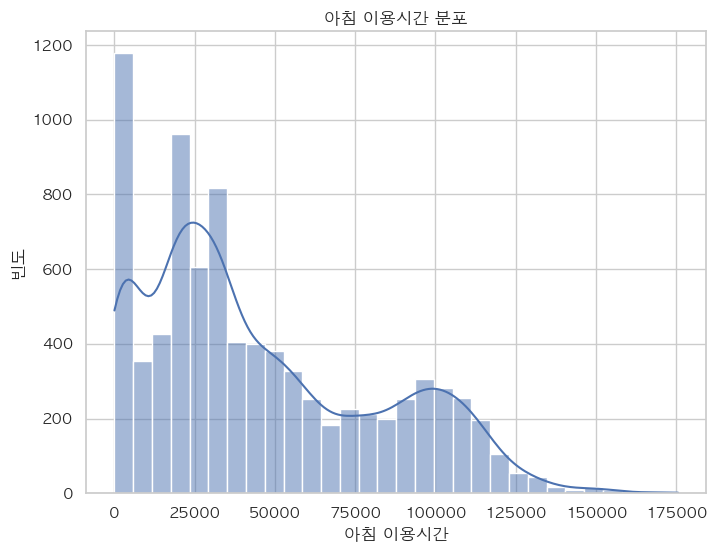

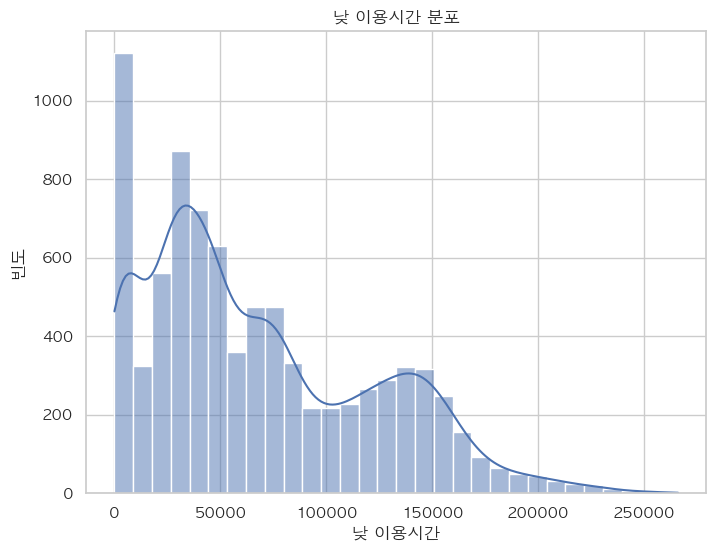

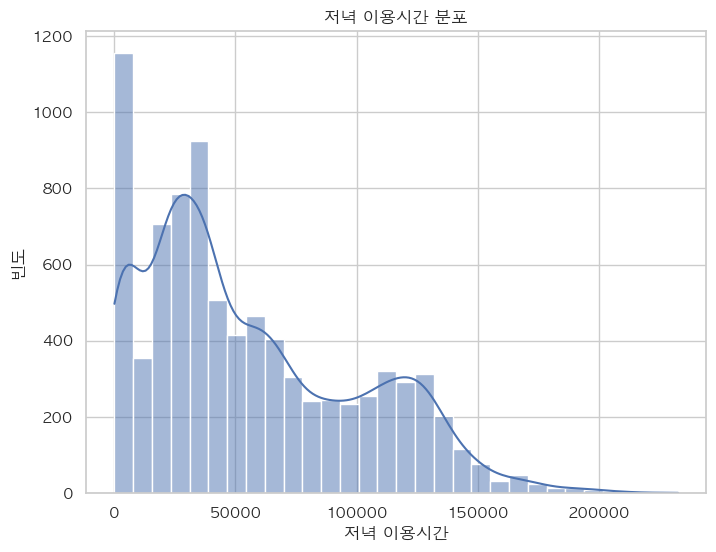

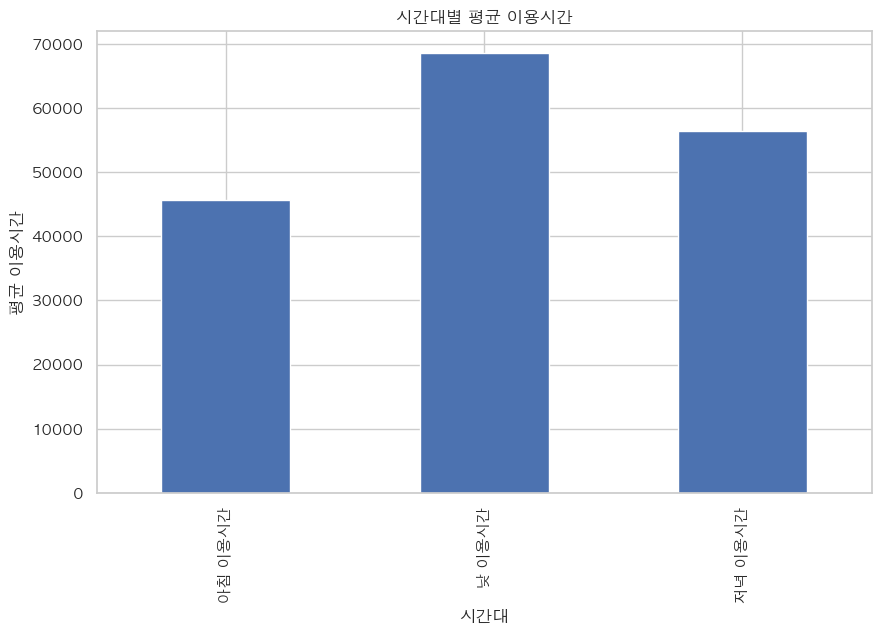

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 시간대별 이용시간 평균
time_usage_means = df[['아침 이용시간', '낮 이용시간', '저녁 이용시간']].mean()

# 히스토그램: 시간대별 이용시간 분포
for col in ['아침 이용시간', '낮 이용시간', '저녁 이용시간']:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'{col} 분포')
    plt.xlabel(col)
    plt.ylabel('빈도')
    plt.show()

# 시간대별 평균 이용시간 시각화
plt.figure(figsize=(10, 6))
time_usage_means.plot(kind='bar')
plt.title('시간대별 평균 이용시간')
plt.xlabel('시간대')
plt.ylabel('평균 이용시간')
plt.show()


시간대별 이용시간 분포
- 아침, 낮, 저녁 이용시간의 히스토그램을 통해, 아침은 낮은 값(0~50,000)에서 높은 빈도를 보였고, 낮과 저녁은 더 높은 값으로 분포가 확장되었습니다.           
- 아침보다 낮 이용시간이 평균적으로 더 길며, 이는 하루 중 낮 시간대의 주차장이 가장 많이 사용된다는 것을 의미합니다.            
**결론: 낮 시간대는 예측 모델에서 중요한 피처로 고려되어야 하며, 아침과 저녁도 보조적인 정보로 포함될 수 있습니다**

### 요일별 이용시간 분석

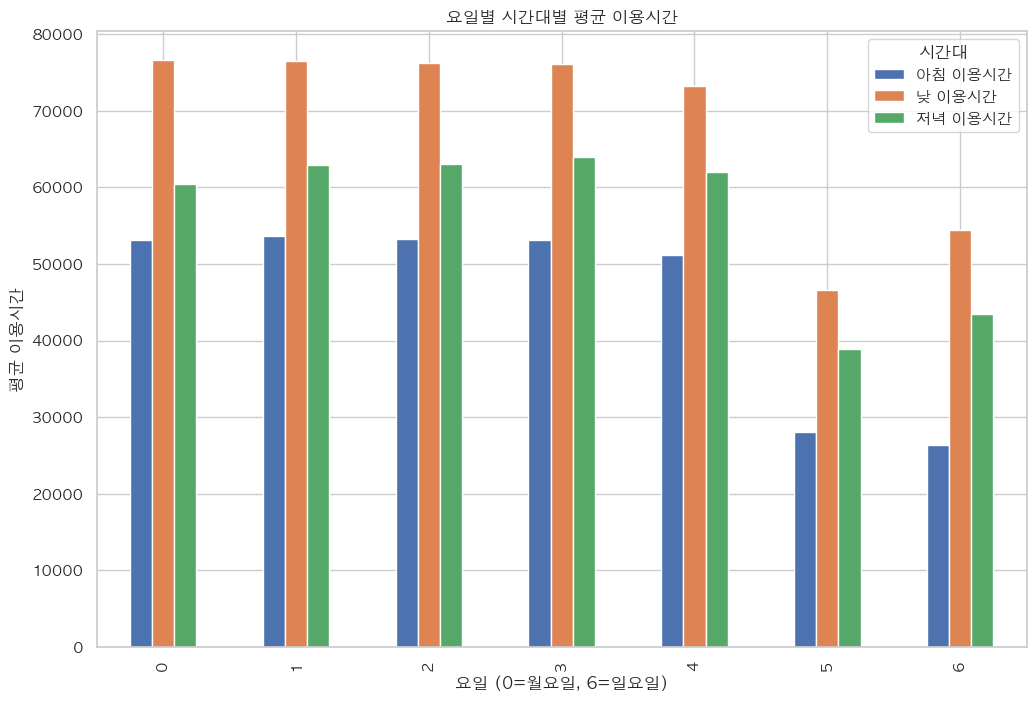

In [ ]:
# 요일별 시간대별 평균 이용시간 계산
weekday_usage = df.groupby('요일')[['아침 이용시간', '낮 이용시간', '저녁 이용시간']].mean()

# 요일별 시간대별 평균 이용시간 시각화
weekday_usage.plot(kind='bar', figsize=(12, 8))
plt.title('요일별 시간대별 평균 이용시간')
plt.xlabel('요일 (0=월요일, 6=일요일)')
plt.ylabel('평균 이용시간')
plt.legend(title='시간대')
plt.show()


시간대별 평균 이용시간
- 낮 이용시간이 평균적으로 가장 길었으며, 아침과 저녁은 상대적으로 낮은 값을 보였습니다.                
- 이는 낮 시간대의 교통량과 방문객 수가 많아지는 경향을 반영하는 것으로 보입니다.           
**결론: 낮 이용시간은 주요 피처로 포함되며, 아침과 저녁은 비교적 보조적 역할을 할 수 있습니다.**        

### 휴일 여부에 따른 이용시간 비교

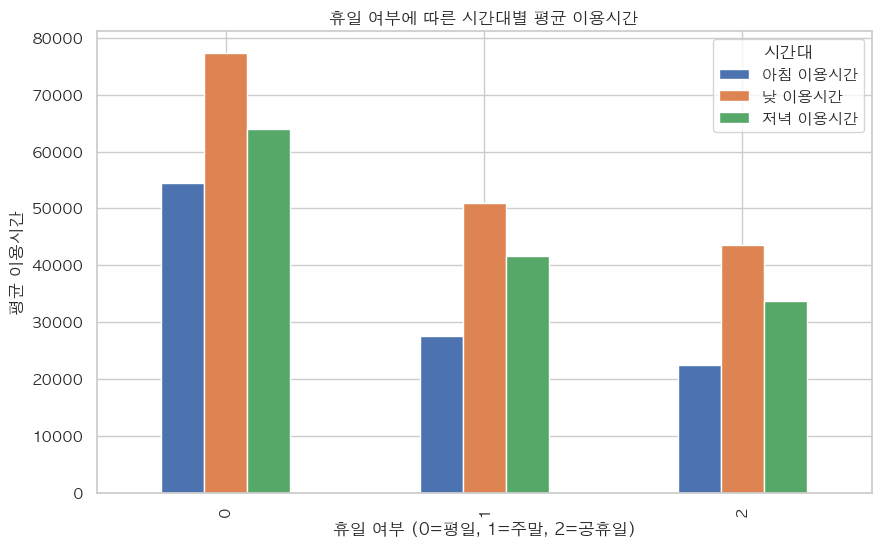

In [ ]:
# 휴일 여부별 시간대별 평균 이용시간 계산
holiday_usage = df.groupby('휴일여부')[['아침 이용시간', '낮 이용시간', '저녁 이용시간']].mean()

# 시각화
holiday_usage.plot(kind='bar', figsize=(10, 6))
plt.title('휴일 여부에 따른 시간대별 평균 이용시간')
plt.xlabel('휴일 여부 (0=평일, 1=주말, 2=공휴일)')
plt.ylabel('평균 이용시간')
plt.legend(title='시간대')
plt.show()


요일별 시간대별 평균 이용시간
- 요일별 분석에서는 주말(토요일과 일요일)의 이용시간이 평일보다 낮게 나타났습니다.              
- 이는 데이터가 특정 기간에 집중되었거나 주말의 일부 시간대에 주차장이 충분히 활용되지 않았기 때문일 수 있습니다.           
- 그러나 일반적인 추세와 다르므로 데이터 수집 과정 또는 특정 변수(날씨, 행사 등)를 추가 검토해야 합니다.            
**결론: 주말 데이터를 별도로 탐색하거나, 날씨와 같은 외부 요인을 포함하여 요일별 이상치를 확인해야 합니다.**        

### 주차대수와 이용시간 간 상관관계 분석

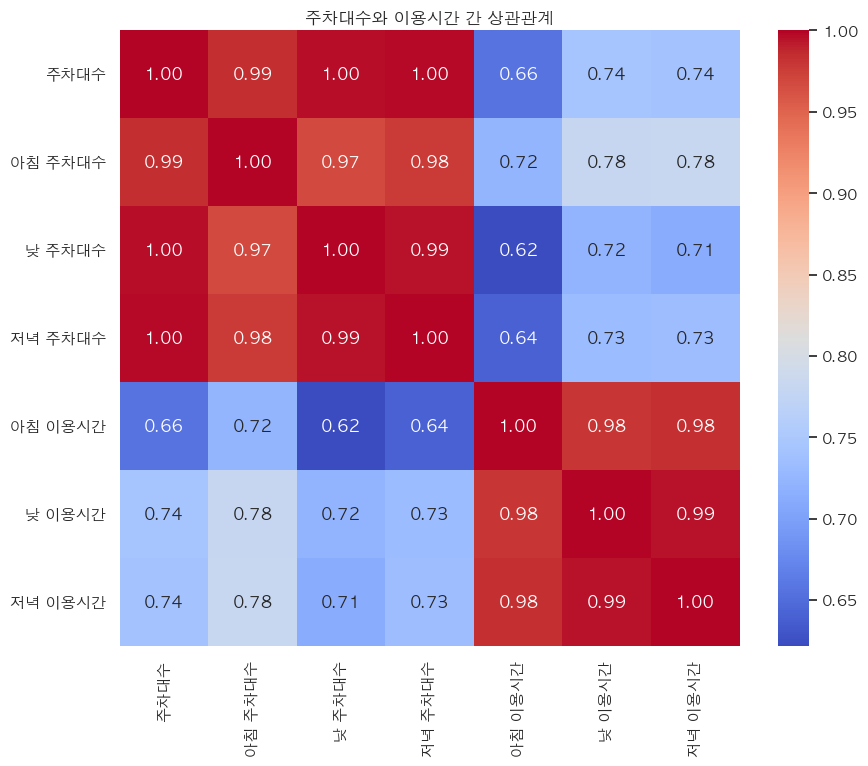

In [ ]:
# 상관관계 계산
corr_matrix = df[['주차대수', '아침 주차대수', '낮 주차대수', '저녁 주차대수', '아침 이용시간', '낮 이용시간', '저녁 이용시간']].corr()

# 히트맵으로 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('주차대수와 이용시간 간 상관관계')
plt.show()


주차대수와 이용시간 간 상관관계
- 전체 주차대수와 낮 이용시간의 상관관계는 0.74로 가장 높았습니다.          
- 아침과 저녁 주차대수 역시 낮은 상관관계를 보이지는 않지만, 상대적으로 낮 이용시간과 더 높은 상관성을 보였습니다.          
결론: 주차대수와 이용시간은 밀접한 상관관계를 가지며, 시간대별 주차대수는 예측 모델에서 중요한 피처가 될 것입니다.

# 주요 피처 선정 이유
    요일:
    요일에 따라 이용시간과 주차 패턴이 달라 혼잡도에 영향을 미침.

    휴일여부:
    평일, 주말, 공휴일의 주차 이용 패턴이 다르게 나타남.

    주차장명:
    주차장별로 주차구획수와 이용 특성이 다름.

    연도, 월, 일:
    계절적 요인과 시간 흐름에 따른 주차 이용 패턴 반영.

### 이용시간 포함여부
이용시간은 모델 입력 피처에 포함되지 않지만, 중간 예측 변수로 사용.

왜 이용시간은 입력 피처가 아닌가에 대하여
- 사용자가 직접 입력할 수 없는 값이기 때문에 모델 입력 피처로 사용 불가.

활용성:
1. 이용시간 예측
- 요일, 휴일여부, 주차장명 등의 입력값으로 이용시간을 예측
2. 시간대별 주차대수 예측
- 예측된 이용시간을 기반으로 아침 주차대수, 낮 주차대수, 저녁 주차대수를 계산.

**결론**
- 이용시간은 최종 타겟 변수(아침, 낮, 저녁 주차대수)를 예측하기 위한 중간 변수로 사용됨.
- 입력 피처는 사용자가 입력할 수 있는 변수로 제한되고, 이용시간은 예측 과정에서 자동 생성.

---
# 모델링

## 모델링 목표
    타겟 변수:
    시간대별 주차 대수: 아침 주차대수, 낮 주차대수, 저녁 주차대수.

    입력 피처:
    요일, 휴일여부, 주차장명, 지구별, 연도, 월, 일.

    결과 출력:
    예측된 시간대별 주차 대수 기반으로 혼잡도(여유, 보통, 혼잡, 만차)를 제공

### 혼잡도 계산 기준
    여유: 예측 주차대수 ≤ 50% * 주차구획수
    보통: 50% < 예측 주차대수 ≤ 80% * 주차구획수
    혼잡: 80% < 예측 주차대수 ≤ 100% * 주차구획수
    만차: 예측 주차대수 > 100% * 주차구획수

### 사용할 모델 리스트
    Models:
        RandomForest Regressor
        GradientBoosting Regressor
        XGBoost Regressor

> 이용시간이 높은 상관관계를 보이나 사용자가 주차 이용시간을 입력하기는 어려움으로 예측 이용시간으로 주차대수를 예측해야 함.

## RandomForest Regressor

### 데이터 준비

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 각 모델용 데이터프레임 복사
df_rf = df.copy()  # 랜덤 포레스트 모델용
df_gb = df.copy()  # 그라디언트 부스팅 모델용
df_xgb = df.copy()  # XGBoost 모델용

# 입력 피처 및 타겟 변수 설정
features = ['요일', '휴일여부', '주차장명', '연도', '월', '일']
target_usage = ['아침 이용시간', '낮 이용시간', '저녁 이용시간']
targets_parking = ['아침 주차대수', '낮 주차대수', '저녁 주차대수']

# 랜덤 포레스트용 데이터 처리
X_rf = pd.get_dummies(df_rf[features])  # 범주형 데이터 원-핫 인코딩
y_rf_usage = df_rf[target_usage]        # 이용시간 타겟
y_rf_parking = df_rf[targets_parking]   # 주차대수 타겟

# 그라디언트 부스팅용 데이터 처리
X_gb = pd.get_dummies(df_gb[features])  # 범주형 데이터 원-핫 인코딩
y_gb_usage = df_gb[target_usage]        # 이용시간 타겟
y_gb_parking = df_gb[targets_parking]   # 주차대수 타겟

# XGBoost용 데이터 처리
X_xgb = pd.get_dummies(df_xgb[features])  # 범주형 데이터 원-핫 인코딩
y_xgb_usage = df_xgb[target_usage]        # 이용시간 타겟
y_xgb_parking = df_xgb[targets_parking]   # 주차대수 타겟

# 데이터 분리 (랜덤 포레스트)
X_train_rf_usage, X_test_rf_usage, y_train_rf_usage, y_test_rf_usage = train_test_split(
    X_rf, y_rf_usage, test_size=0.2
)
X_train_rf_parking, X_test_rf_parking, y_train_rf_parking, y_test_rf_parking = train_test_split(
    X_rf, y_rf_parking, test_size=0.2
)

# 데이터 분리 (그라디언트 부스팅)
X_train_gb_usage, X_test_gb_usage, y_train_gb_usage, y_test_gb_usage = train_test_split(
    X_gb, y_gb_usage, test_size=0.2
)
X_train_gb_parking, X_test_gb_parking, y_train_gb_parking, y_test_gb_parking = train_test_split(
    X_gb, y_gb_parking, test_size=0.2
)

# 데이터 분리 (XGBoost)
X_train_xgb_usage, X_test_xgb_usage, y_train_xgb_usage, y_test_xgb_usage = train_test_split(
    X_xgb, y_xgb_usage, test_size=0.2
)
X_train_xgb_parking, X_test_xgb_parking, y_train_xgb_parking, y_test_xgb_parking = train_test_split(
    X_xgb, y_xgb_parking, test_size=0.2
)


### 이용시간 예측

### 하이퍼파라미터 튜닝 및 최적값 출력

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV

# 랜덤 포레스트 하이퍼파라미터 그리드 설정
param_grid_rf = {
    'estimator__n_estimators': [300, 400, 500],  # 트리 개수
    'estimator__max_depth': [3, 5, 7, 20],  # 최대 깊이
    'estimator__min_samples_split': [2, 5, 10]  # 노드 분할 기준
}

# 랜덤 포레스트 모델 설정
rf_usage_model = MultiOutputRegressor(RandomForestRegressor())

# GridSearchCV 설정
grid_search_rf = GridSearchCV(
    rf_usage_model,
    param_grid_rf,
    scoring='r2',
    cv=3,
    n_jobs=-1,
    return_train_score=True  # 훈련 점수 포함
)

# 학습 및 최적 파라미터 찾기
grid_search_rf.fit(X_train_rf_usage, y_train_rf_usage)

# 최적 하이퍼파라미터 및 교차 검증 성능 출력
rf_best_params = grid_search_rf.best_params_
rf_best_score = grid_search_rf.best_score_

# 훈련 및 테스트 점수 계산
rf_train_score = grid_search_rf.score(X_train_rf_usage, y_train_rf_usage)  # 훈련 데이터 점수
rf_test_score = grid_search_rf.score(X_test_rf_usage, y_test_rf_usage)  # 테스트 데이터 점수

print("랜덤 포레스트 최적 하이퍼파라미터:", rf_best_params)
print("랜덤 포레스트 최고 R² 점수 (교차 검증):", rf_best_score)
print("랜덤 포레스트 훈련 R² 점수:", rf_train_score)
print("랜덤 포레스트 테스트 R² 점수:", rf_test_score)

랜덤 포레스트 최적 하이퍼파라미터: {'estimator__max_depth': 20, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 500}
랜덤 포레스트 최고 R² 점수 (교차 검증): 0.8325337034967042
랜덤 포레스트 훈련 R² 점수: 0.9797754947050034
랜덤 포레스트 테스트 R² 점수: 0.8256204501370945


### 최적 모델로 예측 및 평가

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 최적 모델로 예측
best_rf_model = grid_search_rf.best_estimator_
predicted_rf_usage = best_rf_model.predict(X_test_rf_usage)

# 평가 지표 계산
mse_usage = mean_squared_error(y_test_rf_usage, predicted_rf_usage)
mae_usage = mean_absolute_error(y_test_rf_usage, predicted_rf_usage)
r2_usage = r2_score(y_test_rf_usage, predicted_rf_usage)

# 결과 출력
print(f"최적 랜덤 포레스트 모델 평가 결과:")
print(f" - MSE: {mse_usage:.2f}")
print(f" - MAE: {mae_usage:.2f}")
print(f" - R²: {r2_usage:.2f}")

최적 랜덤 포레스트 모델 평가 결과:
 - MSE: 359737969.96
 - MAE: 10421.03
 - R²: 0.83


### 하이퍼파라미터 성능 시각화

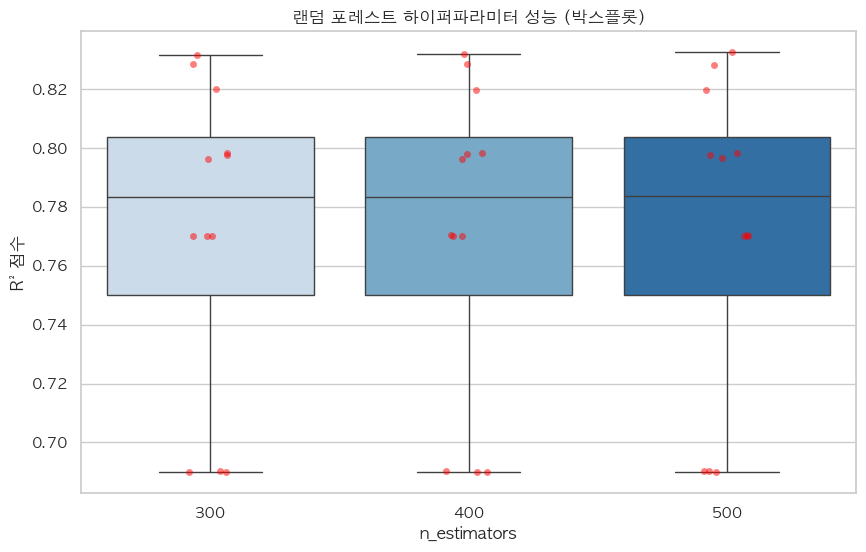

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# GridSearchCV 결과에서 데이터 추출
cv_results = pd.DataFrame(grid_search_rf.cv_results_)

# `n_estimators` 별로 R² 점수를 추출
cv_results['n_estimators'] = cv_results['param_estimator__n_estimators']
cv_results['R2'] = cv_results['mean_test_score']

plt.figure(figsize=(10, 6))
sns.boxplot(x='n_estimators', y='R2', data=cv_results, palette='Blues')
sns.stripplot(x='n_estimators', y='R2', data=cv_results, color='red', alpha=0.5)
plt.title('랜덤 포레스트 하이퍼파라미터 성능 (박스플롯)')
plt.xlabel('n_estimators')
plt.ylabel('R² 점수')
plt.show()

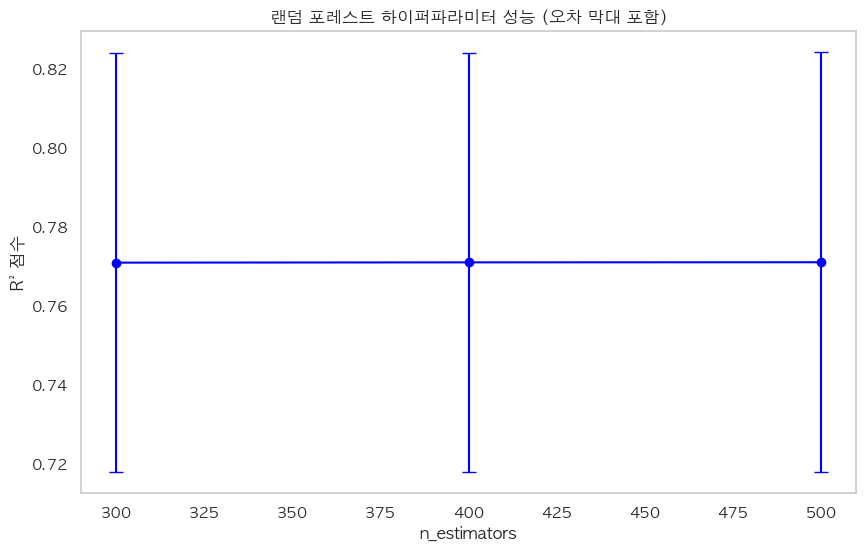

In [ ]:
# 평균 및 표준편차 계산
error_data = cv_results.groupby('n_estimators').agg(
    mean_R2=('mean_test_score', 'mean'),
    std_R2=('mean_test_score', 'std')
).reset_index()

plt.figure(figsize=(10, 6))
plt.errorbar(
    error_data['n_estimators'],
    error_data['mean_R2'],
    yerr=error_data['std_R2'],
    fmt='-o',
    capsize=5,
    color='blue'
)
plt.title('랜덤 포레스트 하이퍼파라미터 성능 (오차 막대 포함)')
plt.xlabel('n_estimators')
plt.ylabel('R² 점수')
plt.grid()
plt.show()

$R^2$ 점수가 n_estimators 500에서 가장 좋은 것을 확인할 수 있다.

### 예측값 vs 실제값 비교 그래프

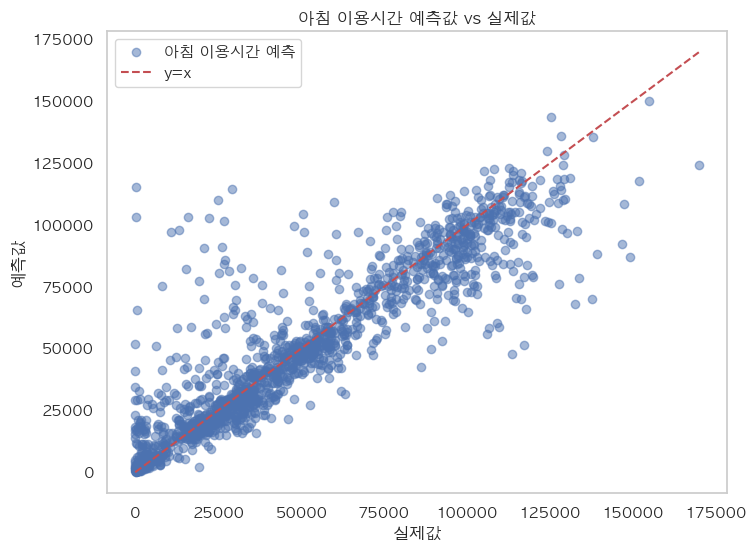

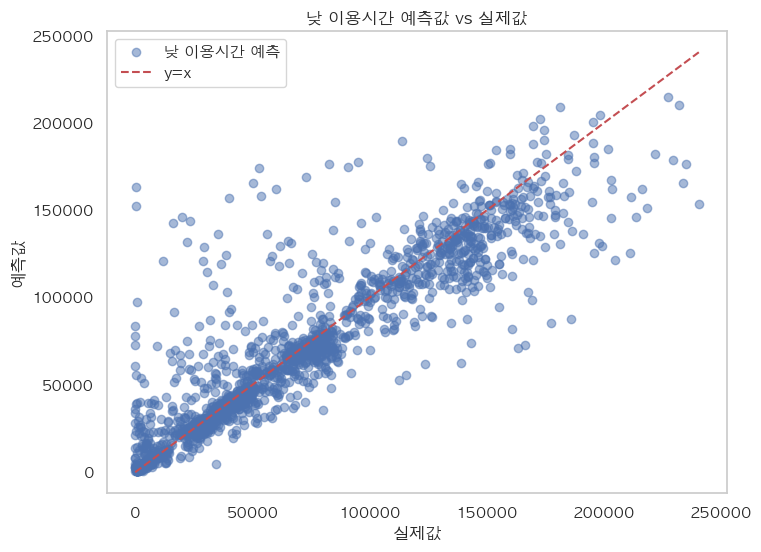

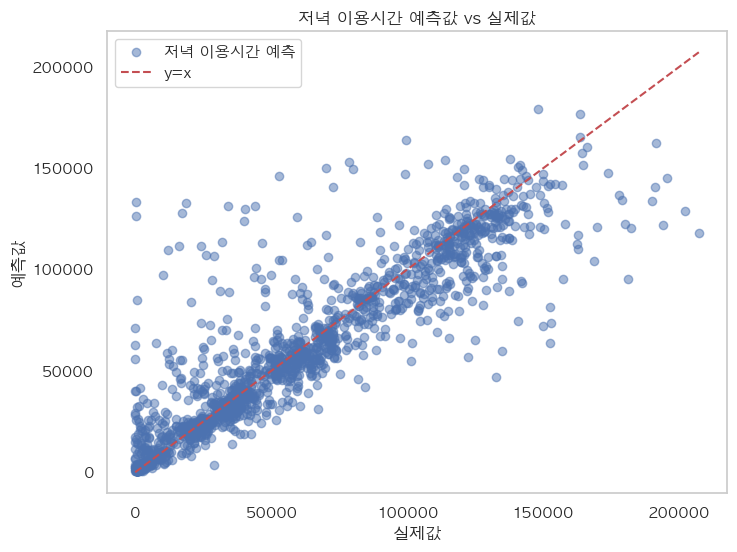

In [ ]:
# 예측값 vs 실제값 비교
time_periods = ['아침 이용시간', '낮 이용시간', '저녁 이용시간']

for idx, time in enumerate(time_periods):
    plt.figure(figsize=(8, 6))
    plt.scatter(
        y_test_rf_usage.iloc[:, idx], predicted_rf_usage[:, idx],
        alpha=0.5, label=f"{time} 예측"
    )
    plt.plot(
        [y_test_rf_usage.iloc[:, idx].min(), y_test_rf_usage.iloc[:, idx].max()],
        [y_test_rf_usage.iloc[:, idx].min(), y_test_rf_usage.iloc[:, idx].max()],
        'r--', label='y=x'
    )
    plt.xlabel('실제값')
    plt.ylabel('예측값')
    plt.title(f"{time} 예측값 vs 실제값")
    plt.legend()
    plt.grid()
    plt.show()

### 오차 분포 그래프

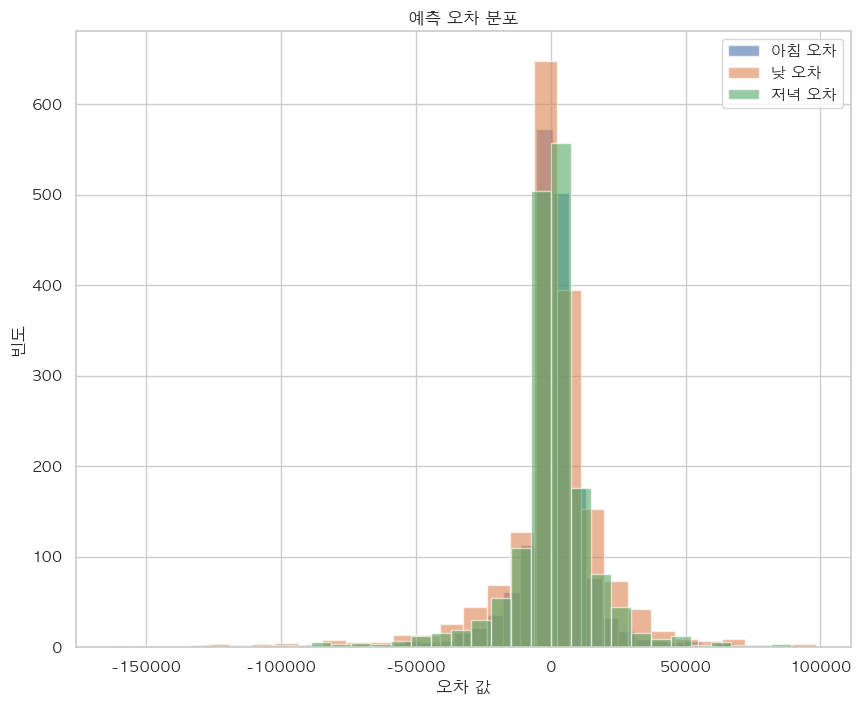

In [ ]:
# 오차 분포 히스토그램
time_periods = ['아침', '낮', '저녁']
errors = y_test_rf_usage - predicted_rf_usage
plt.figure(figsize=(10, 8))
for idx, time in enumerate(time_periods):
    plt.hist(errors.iloc[:, idx], bins=30, alpha=0.6, label=f'{time} 오차')
plt.xlabel('오차 값')
plt.ylabel('빈도')
plt.title('예측 오차 분포')
plt.legend()
plt.show()

> 회귀선에 점들이 모여있고, 오차분포 그래프가 0에 가까운 것이 많기 때문에 모델이 전반적으로 잘 동작하는 것을 알 수 있다.

## 시간대별 주차대수 예측 모델

### 데이터 준비

### 주차대수 예측 모델 학습 및 하이퍼파라미터 튜닝

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

# 교차 검증 및 하이퍼파라미터 튜닝 결과 저장
kf = KFold(n_splits=5, shuffle=True)
rf_train_scores = []  # Fold별 훈련 점수
rf_test_scores = []   # Fold별 테스트 점수

# 랜덤 포레스트 모델 초기 설정
rf_parking_model = RandomForestRegressor(n_estimators=100)

for train_index, test_index in kf.split(X_train_rf_parking):
    # Fold별 데이터 분리
    X_train_fold, X_test_fold = X_train_rf_parking.iloc[train_index], X_train_rf_parking.iloc[test_index]
    y_train_fold, y_test_fold = y_train_rf_parking.iloc[train_index], y_train_rf_parking.iloc[test_index]
    
    # Fold별 모델 학습
    rf_parking_model.fit(X_train_fold, y_train_fold)
    
    # 점수 계산
    rf_train_scores.append(rf_parking_model.score(X_train_fold, y_train_fold))
    rf_test_scores.append(rf_parking_model.score(X_test_fold, y_test_fold))

# 하이퍼파라미터 튜닝 설정
param_grid_rf_parking = {
    'estimator__n_estimators': [100, 200, 300, 400, 500],
    'estimator__max_depth': [10, 20, None],
    'estimator__min_samples_split': [2, 5, 10]
}

# MultiOutputRegressor를 사용한 GridSearchCV
rf_multi_model = MultiOutputRegressor(RandomForestRegressor())
grid_search_parking = GridSearchCV(
    rf_multi_model,
    param_grid_rf_parking,# 하이퍼파라미터
    scoring='r2', # R2 점수출력
    cv=3, # 3-Fold 교차 검증
    n_jobs=-1, # 병렬 처리
    return_train_score=True
)

# 모델 학습 및 최적 하이퍼파라미터 찾기
grid_search_parking.fit(X_train_rf_parking, y_train_rf_parking)

# 최적 하이퍼파라미터 및 점수 출력
rf_best_params = grid_search_parking.best_params_
rf_best_score = grid_search_parking.best_score_

print("최적 하이퍼파라미터:", rf_best_params)
print("최고 R² 점수 (교차 검증):", rf_best_score)

최적 하이퍼파라미터: {'estimator__max_depth': 20, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 500}
최고 R² 점수 (교차 검증): 0.8239778944453997


In [ ]:
# 교차 검증 결과 저장
rf_results = pd.DataFrame(grid_search_parking.cv_results_)

### 최적 모델로 테스터 데이터 예측

In [ ]:
# 최적 모델로 테스트 데이터 예측
rf_final_parking_model = grid_search_parking.best_estimator_
rf_predicted_parking = rf_final_parking_model.predict(X_test_rf_parking)

# 훈련 및 테스트 데이터에서 모델 성능 평가
rf_train_score_parking = rf_final_parking_model.score(X_train_rf_parking, y_train_rf_parking)
rf_test_score_parking = rf_final_parking_model.score(X_test_rf_parking, y_test_rf_parking)

print(f"훈련 점수 (R²): {rf_train_score_parking:.2f}")
print(f"테스트 점수 (R²): {rf_test_score_parking:.2f}")

훈련 점수 (R²): 0.98
테스트 점수 (R²): 0.84


### 실제값 예측값

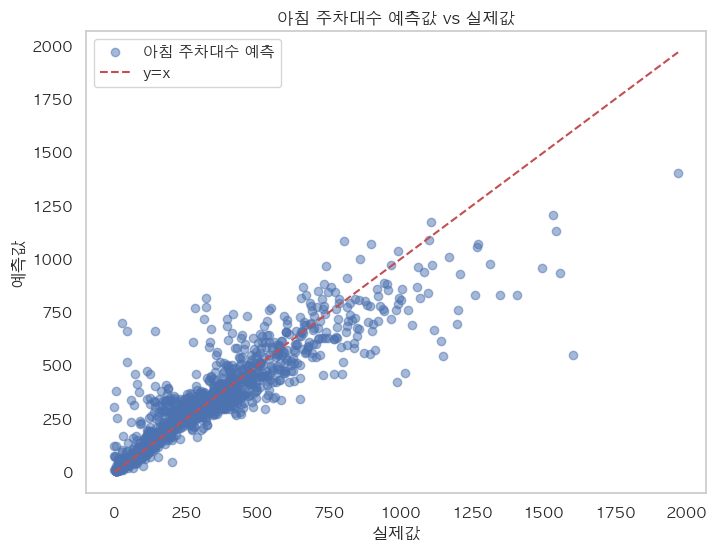

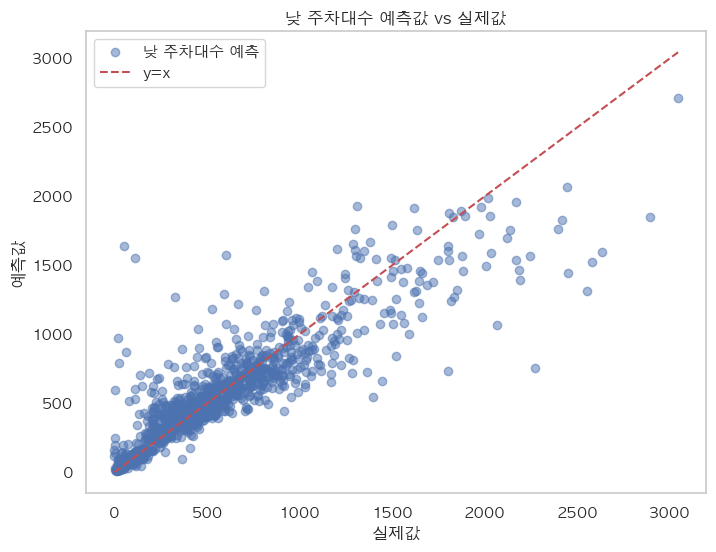

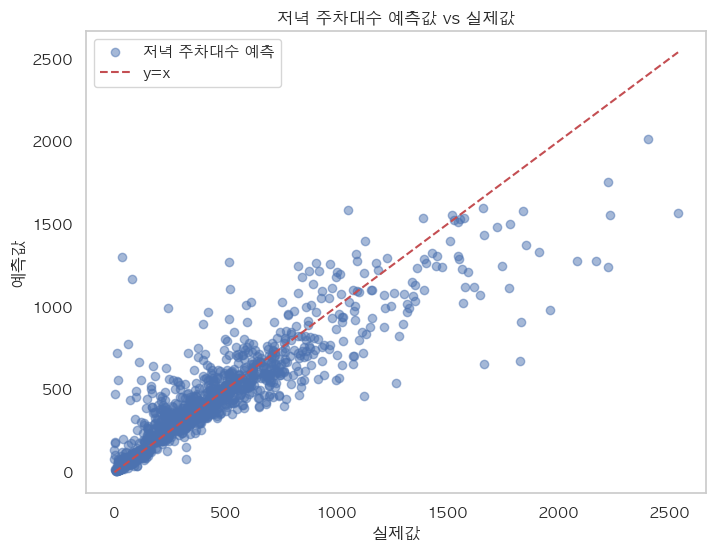

In [ ]:
# 예측값 vs 실제값 비교 (주차대수)
time_periods_parking = ['아침 주차대수', '낮 주차대수', '저녁 주차대수']

for idx, time in enumerate(time_periods_parking):
    plt.figure(figsize=(8, 6))
    plt.scatter(
        y_test_rf_parking.iloc[:, idx], rf_predicted_parking[:, idx],
        alpha=0.5, label=f"{time} 예측"
    )
    plt.plot(
        [y_test_rf_parking.iloc[:, idx].min(), y_test_rf_parking.iloc[:, idx].max()],
        [y_test_rf_parking.iloc[:, idx].min(), y_test_rf_parking.iloc[:, idx].max()],
        'r--', label='y=x'
    )
    plt.xlabel('실제값')
    plt.ylabel('예측값')
    plt.title(f"{time} 예측값 vs 실제값")
    plt.legend()
    plt.grid()
    plt.show()

### 훈련점수와 테스트 점수 비교 그래프

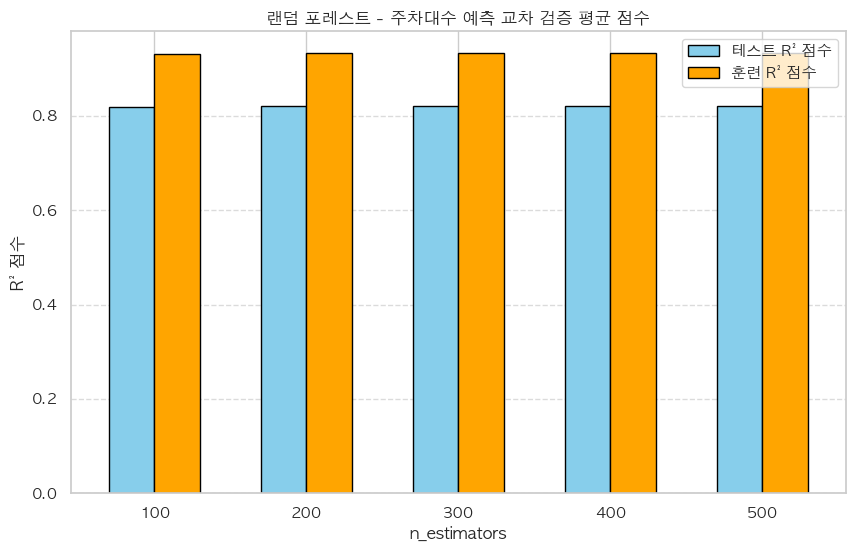

In [ ]:
import matplotlib.pyplot as plt

# n_estimators에 따른 평균 점수 계산
rf_results['n_estimators'] = rf_results['param_estimator__n_estimators'].astype(int)
grouped_scores = rf_results.groupby('n_estimators')[['mean_test_score', 'mean_train_score']].mean()

# 막대그래프 그리기
grouped_scores.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange'], edgecolor='black', width=0.6)
plt.title('랜덤 포레스트 - 주차대수 예측 교차 검증 평균 점수')
plt.xlabel('n_estimators')
plt.ylabel('R² 점수')
plt.xticks(rotation=0)
plt.legend(['테스트 R² 점수', '훈련 R² 점수'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 하이퍼파라미터 튜닝 시각화

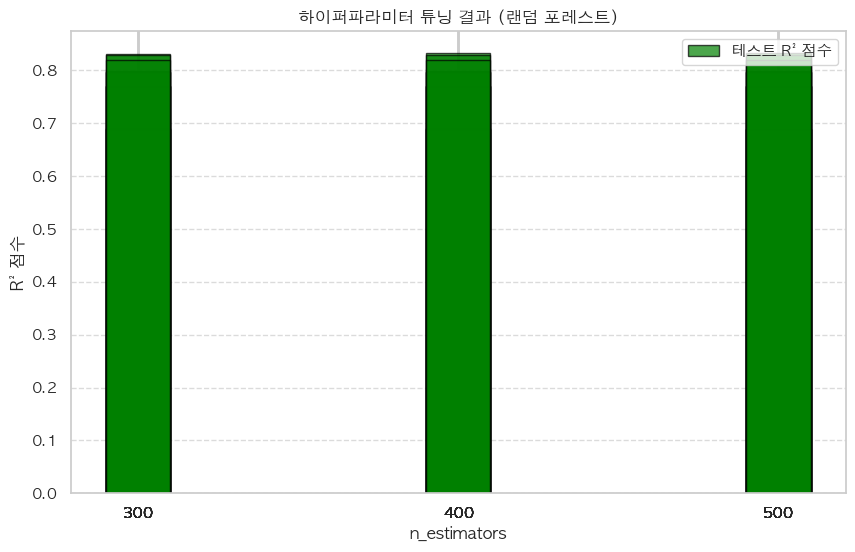

In [ ]:
# 하이퍼파라미터 튜닝 결과 시각화
param_values = [param['estimator__n_estimators'] for param in cv_results['params'] if 'estimator__n_estimators' in param]
mean_test_scores = cv_results['mean_test_score']

plt.figure(figsize=(10, 6))
plt.bar(param_values, mean_test_scores, color='green', edgecolor='black', alpha=0.7, label='테스트 R² 점수', width=20)
plt.title('하이퍼파라미터 튜닝 결과 (랜덤 포레스트)')
plt.xlabel('n_estimators')
plt.ylabel('R² 점수')
plt.xticks(param_values)  # x축 값 설정
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)  # y축에만 격자 추가
plt.show()

### Fold별 교차 검증

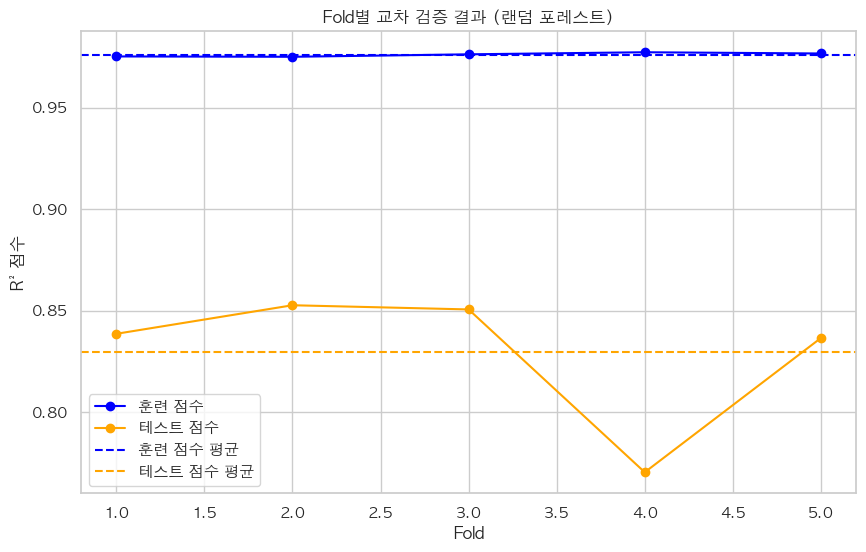

In [ ]:
# Fold별 교차 검증 점수 시각화
import matplotlib.pyplot as plt
import numpy as np

# Fold 개수
folds = range(1, len(rf_train_scores) + 1)

plt.figure(figsize=(10, 6))
plt.plot(folds, rf_train_scores, marker='o', label='훈련 점수', color='blue')
plt.plot(folds, rf_test_scores, marker='o', label='테스트 점수', color='orange')
plt.axhline(y=np.mean(rf_train_scores), color='blue', linestyle='--', label='훈련 점수 평균')
plt.axhline(y=np.mean(rf_test_scores), color='orange', linestyle='--', label='테스트 점수 평균')
plt.title('Fold별 교차 검증 결과 (랜덤 포레스트)')
plt.xlabel('Fold')
plt.ylabel('R² 점수')
plt.legend()
plt.grid(True)
plt.show()

> 훈련 점수는 꾸준히 높은 값을 유지하지만 Fold에 따라 테스트 점수는 약간의 변동이 있다. 

### MAE와 MSE 시각화 코드

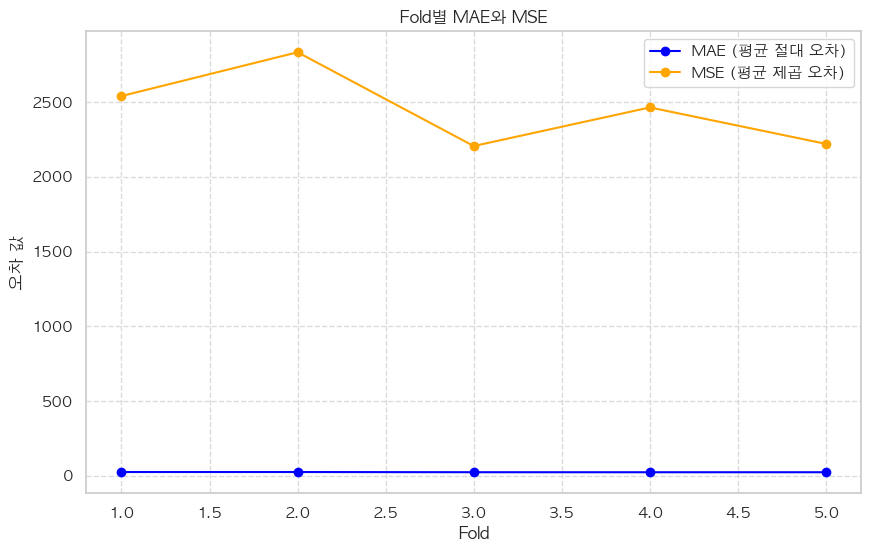

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# MAE와 MSE 저장 리스트
mae_scores = []
mse_scores = []

# KFold로 Fold별 데이터 분리 및 성능 계산
kf = KFold(n_splits=5, shuffle=True)

for train_index, test_index in kf.split(X_train_rf_parking):
    # Fold별 데이터 분리
    X_test_fold = X_train_rf_parking.iloc[test_index]
    y_test_fold = y_train_rf_parking.iloc[test_index]
    
    # 예측값 생성
    rf_predictions = rf_final_parking_model.predict(X_test_fold)
    
    # 실제값과 예측값 비교
    mae_scores.append(mean_absolute_error(y_test_fold, rf_predictions))
    mse_scores.append(mean_squared_error(y_test_fold, rf_predictions))

# Fold 번호 생성
folds = range(1, len(mae_scores) + 1)

# MAE와 MSE 시각화
plt.figure(figsize=(10, 6))
plt.plot(folds, mae_scores, marker='o', label='MAE (평균 절대 오차)', color='blue')
plt.plot(folds, mse_scores, marker='o', label='MSE (평균 제곱 오차)', color='orange')
plt.title('Fold별 MAE와 MSE')
plt.xlabel('Fold')
plt.ylabel('오차 값')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

> MAE 값은 오차의 평균값으로 낮은 오차값을 가지며 정확히 예측한 것을 알 수 있다.    
  MSE 값은 오차의 평균 제곱값으로 첫 번째 Fold에서는 매우 높지만 이후 Fold에서 낮아지는 경향을 보입니다.      
  Fold는 1에서 불안정했으나 이후 안정화되었으므로 Fold 5가 최적의 평가 기준이 될 것으로 보임

### 혼잡도 계산

In [ ]:
# 전체 데이터프레임에서 입력 피처 추출 (df_rf 기준)
X_full = pd.get_dummies(df_rf[features])

# 전체 데이터에 대해 예측
rf_predicted_parking_full = rf_final_parking_model.predict(X_full)

# 예측값을 데이터프레임에 추가
df_rf[['예측 아침 주차대수', '예측 낮 주차대수', '예측 저녁 주차대수']] = rf_predicted_parking_full

# 결과 확인
print(df_rf[['예측 아침 주차대수', '예측 낮 주차대수', '예측 저녁 주차대수']].head())

   예측 아침 주차대수   예측 낮 주차대수  예측 저녁 주차대수
0   446.23696  584.595558  512.780692
1   103.47984  135.118160  114.468840
2   664.99664  851.961360  745.505720
3   770.65558  992.406400  875.447200
4    59.77970   76.330760   65.810760


In [ ]:
# 혼잡도 계산 함수
def calculate_congestion(parking_count, capacity):
    ratio = parking_count / capacity
    if ratio <= 0.5:
        return '여유'
    elif ratio <= 0.8:
        return '보통'
    elif ratio <= 1.0:
        return '혼잡'
    else:
        return '만차'

# 혼잡도 계산 및 데이터 추가
for time in ['아침', '낮', '저녁']:
    df_rf[f'예측 {time} 혼잡도'] = df_rf.apply(
        lambda row: calculate_congestion(row[f'예측 {time} 주차대수'], row['주차구획수']),
        axis=1
    )

# 최종 결과 데이터프레임
rf_final_result = df_rf[['날짜', '주차장명', '예측 아침 혼잡도', '예측 낮 혼잡도', '예측 저녁 혼잡도']]
print(rf_final_result.head())


          날짜     주차장명 예측 아침 혼잡도 예측 낮 혼잡도 예측 저녁 혼잡도
0 2024-09-30  여의도3주차장        보통       보통        보통
1 2024-09-30  여의도5주차장        보통       혼잡        혼잡
2 2024-09-30  여의도2주차장        만차       만차        만차
3 2024-09-30  여의도1주차장        만차       만차        만차
4 2024-09-30  여의도4주차장        여유       여유        여유


### 혼잡도 분포 그래프

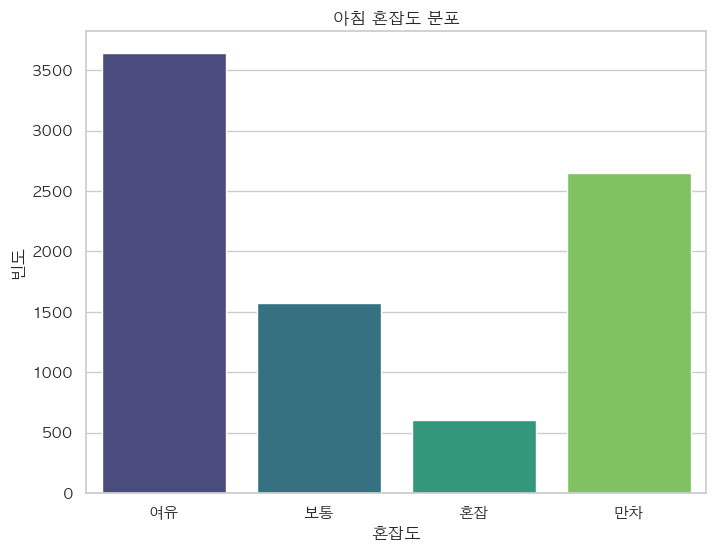

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 혼잡도 분포
plt.figure(figsize=(8, 6))
sns.countplot(
    data=df_rf,
    x='예측 아침 혼잡도',
    order=["여유", "보통", "혼잡", "만차"],
    palette="viridis"
)
plt.title('아침 혼잡도 분포')
plt.xlabel('혼잡도')
plt.ylabel('빈도')
plt.show()

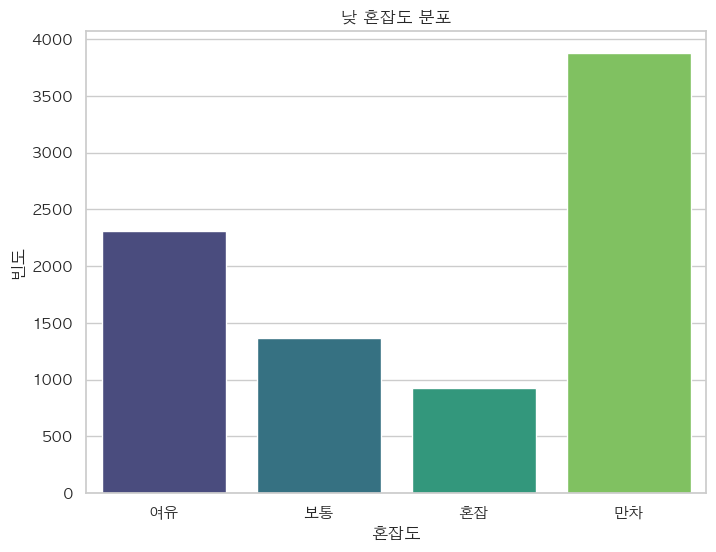

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 혼잡도 분포
plt.figure(figsize=(8, 6))
sns.countplot(
    data=df_rf,
    x='예측 낮 혼잡도',
    order=["여유", "보통", "혼잡", "만차"],
    palette="viridis"
)
plt.title('낮 혼잡도 분포')
plt.xlabel('혼잡도')
plt.ylabel('빈도')
plt.show()

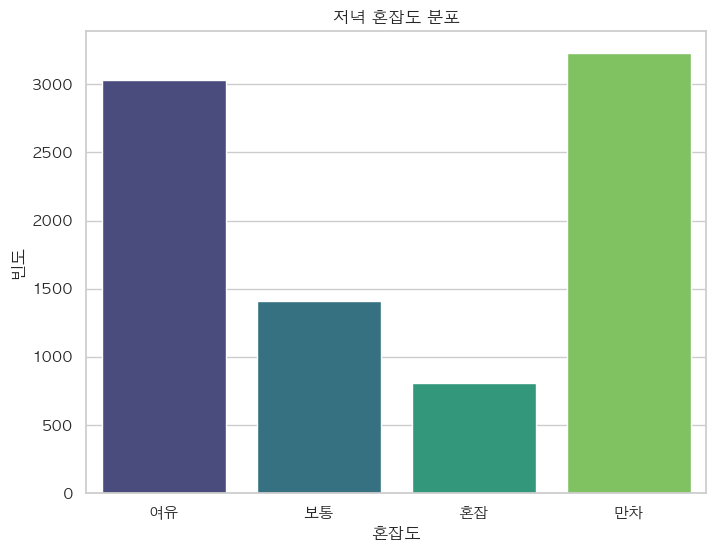

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 혼잡도 분포
plt.figure(figsize=(8, 6))
sns.countplot(
    data=df_rf,
    x='예측 저녁 혼잡도',
    order=["여유", "보통", "혼잡", "만차"],
    palette="viridis"
)
plt.title('저녁 혼잡도 분포')
plt.xlabel('혼잡도')
plt.ylabel('빈도')
plt.show()

### 시간대별 혼잡도 비율 그래프

혼잡도              만차        보통        여유        혼잡
시간대                                              
예측 낮 혼잡도   0.152448  0.053805  0.090737  0.036342
예측 아침 혼잡도  0.104228  0.062065  0.143166  0.023874
예측 저녁 혼잡도  0.126922  0.055339  0.119135  0.031937


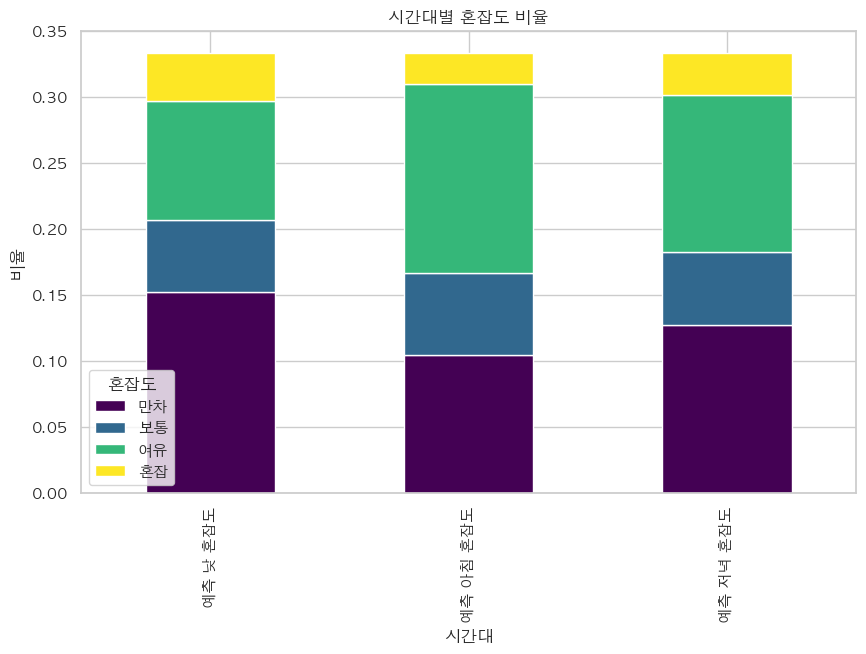

In [ ]:
# 시간대별 혼잡도 비율 계산
time_periods = ['예측 아침 혼잡도', '예측 낮 혼잡도', '예측 저녁 혼잡도']

# 혼잡도 값들을 집계하여 비율 계산
congestion_ratios = (
    df_rf[time_periods]
    .melt(var_name='시간대', value_name='혼잡도')
    .groupby(['시간대', '혼잡도'])
    .size()
    .unstack(fill_value=0)
    .div(df_rf[time_periods].count(axis=0).sum())
)
print(congestion_ratios)  # 비율 데이터 확인


# 시간대별 혼잡도 비율 그래프
congestion_ratios.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('시간대별 혼잡도 비율')
plt.xlabel('시간대')
plt.ylabel('비율')
plt.legend(title='혼잡도')
plt.show()

## GradientBoosting Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV

# 랜덤 포레스트 하이퍼파라미터 그리드 설정
param_grid_gb = {
    'estimator__n_estimators': [300, 400, 500],  # 트리 개수
    'estimator__learning_rate': [0.05, 0.1, 0.2], # 학습
    'estimator__max_depth': [3, 5, 7]  # 최대 깊이
}

# 랜덤 포레스트 모델 설정
gb_usage_model = MultiOutputRegressor(GradientBoostingRegressor())

# GridSearchCV 설정
grid_search_gb = GridSearchCV(
    gb_usage_model,
    param_grid_gb,
    scoring='r2',
    cv=3,
    n_jobs=-1,
    return_train_score=True  # 훈련 점수 포함
)

# 학습 및 최적 파라미터 찾기
grid_search_gb.fit(X_train_gb_usage, y_train_gb_usage)

# 최적 하이퍼파라미터 및 교차 검증 성능 출력
gb_best_params = grid_search_gb.best_params_
gb_best_score = grid_search_gb.best_score_

# 훈련 및 테스트 점수 계산
gb_train_score = grid_search_gb.score(X_train_gb_usage, y_train_gb_usage)  # 훈련 데이터 점수
gb_test_score = grid_search_gb.score(X_test_gb_usage, y_test_gb_usage)  # 테스트 데이터 점수

print("그라디언트 부스팅 최적 하이퍼파라미터:", gb_best_params)
print("그라디언트 부스팅 최고 R² 점수 (교차 검증):", gb_best_score)
print("그라디언트 부스팅 훈련 R² 점수:", gb_train_score)
print("그라디언트 부스팅 테스트 R² 점수:", gb_test_score)

그라디언트 부스팅 최적 하이퍼파라미터: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 7, 'estimator__n_estimators': 300}
그라디언트 부스팅 최고 R² 점수 (교차 검증): 0.8496418089106944
그라디언트 부스팅 훈련 R² 점수: 0.9853979846374981
그라디언트 부스팅 테스트 R² 점수: 0.8890134630552594


### 최적 모델로 예측 및 평가

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 최적 모델로 예측
best_gb_model = grid_search_gb.best_estimator_
predicted_gb_usage = best_gb_model.predict(X_test_gb_usage)

# 평가 지표 계산
mse_gb_usage = mean_squared_error(y_test_gb_usage, predicted_gb_usage)
mae_gb_usage = mean_absolute_error(y_test_gb_usage, predicted_gb_usage)
r2_gb_usage = r2_score(y_test_gb_usage, predicted_gb_usage)

# 결과 출력
print(f"최적 그라디언트 부스팅 모델 평가 결과:")
print(f" - MSE: {mse_gb_usage:.2f}")
print(f" - MAE: {mae_gb_usage:.2f}")
print(f" - R²: {r2_gb_usage:.2f}")

최적 그라디언트 부스팅 모델 평가 결과:
 - MSE: 231564078.62
 - MAE: 9003.17
 - R²: 0.89


### 하이퍼파라미터 성능 시각화

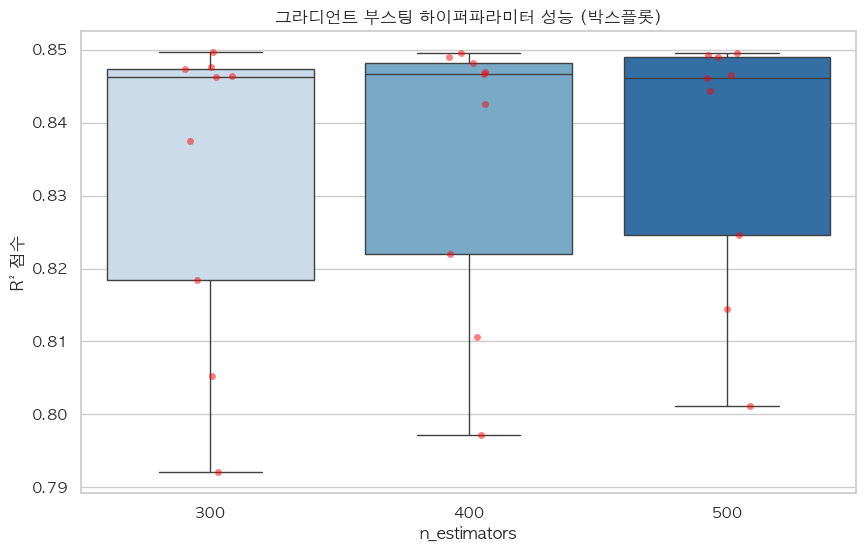

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# GridSearchCV 결과에서 데이터 추출
gb_cv_results = pd.DataFrame(grid_search_gb.cv_results_)

# `n_estimators` 별로 R² 점수를 추출
gb_cv_results['n_estimators'] = gb_cv_results['param_estimator__n_estimators']
gb_cv_results['R2'] = gb_cv_results['mean_test_score']

plt.figure(figsize=(10, 6))
sns.boxplot(x='n_estimators', y='R2', data=gb_cv_results, palette='Blues')
sns.stripplot(x='n_estimators', y='R2', data=gb_cv_results, color='red', alpha=0.5)
plt.title('그라디언트 부스팅 하이퍼파라미터 성능 (박스플롯)')
plt.xlabel('n_estimators')
plt.ylabel('R² 점수')
plt.show()

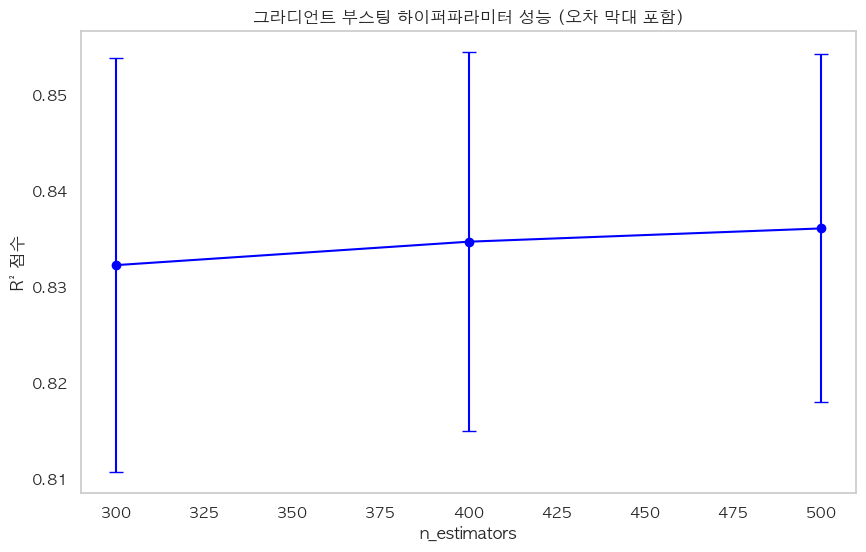

In [ ]:
# 평균 및 표준편차 계산
gb_error_data = gb_cv_results.groupby('n_estimators').agg(
    mean_R2=('mean_test_score', 'mean'),
    std_R2=('mean_test_score', 'std')
).reset_index()

plt.figure(figsize=(10, 6))
plt.errorbar(
    gb_error_data['n_estimators'],
    gb_error_data['mean_R2'],
    yerr=gb_error_data['std_R2'],
    fmt='-o',
    capsize=5,
    color='blue'
)
plt.title('그라디언트 부스팅 하이퍼파라미터 성능 (오차 막대 포함)')
plt.xlabel('n_estimators')
plt.ylabel('R² 점수')
plt.grid()
plt.show()

> $R^2$ 점수가 n_estimators 3500에서 가장 높은 성적을 내는 것을 알 수 있다.

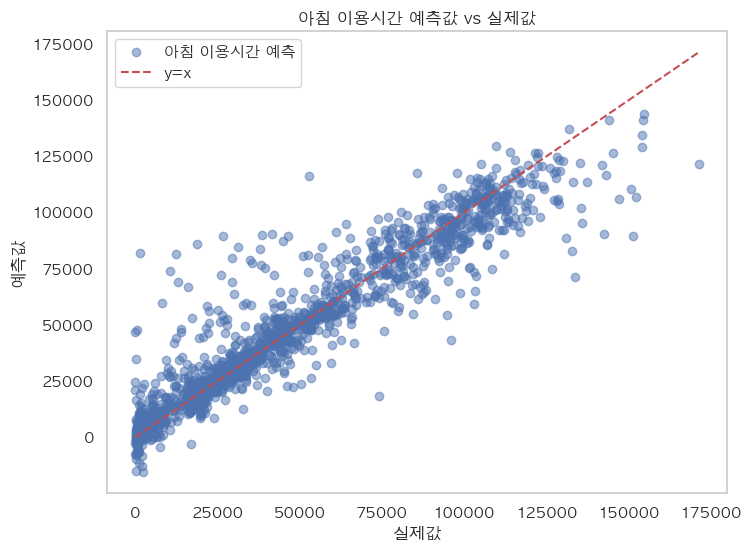

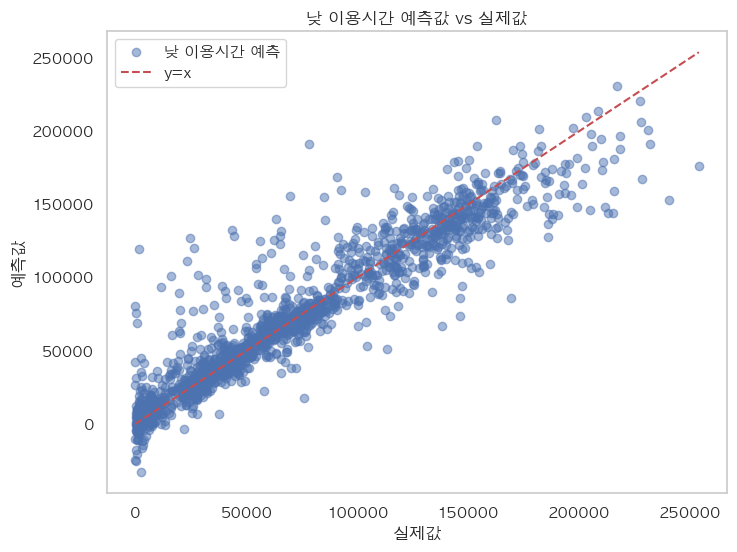

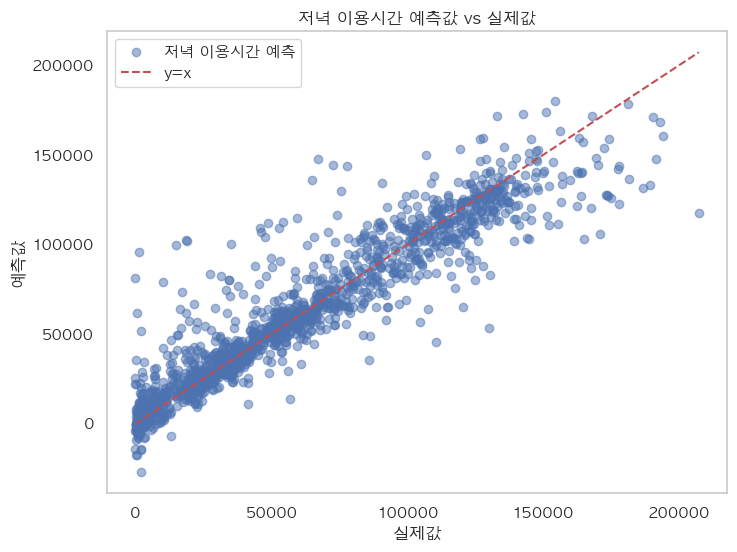

In [ ]:
# 예측값 vs 실제값 비교
time_periods = ['아침 이용시간', '낮 이용시간', '저녁 이용시간']

for idx, time in enumerate(time_periods):
    plt.figure(figsize=(8, 6))
    plt.scatter(
        y_test_gb_usage.iloc[:, idx], predicted_gb_usage[:, idx],
        alpha=0.5, label=f"{time} 예측"
    )
    plt.plot(
        [y_test_gb_usage.iloc[:, idx].min(), y_test_gb_usage.iloc[:, idx].max()],
        [y_test_gb_usage.iloc[:, idx].min(), y_test_gb_usage.iloc[:, idx].max()],
        'r--', label='y=x'
    )
    plt.xlabel('실제값')
    plt.ylabel('예측값')
    plt.title(f"{time} 예측값 vs 실제값")
    plt.legend()
    plt.grid()
    plt.show()

### 오차 분포 그래프

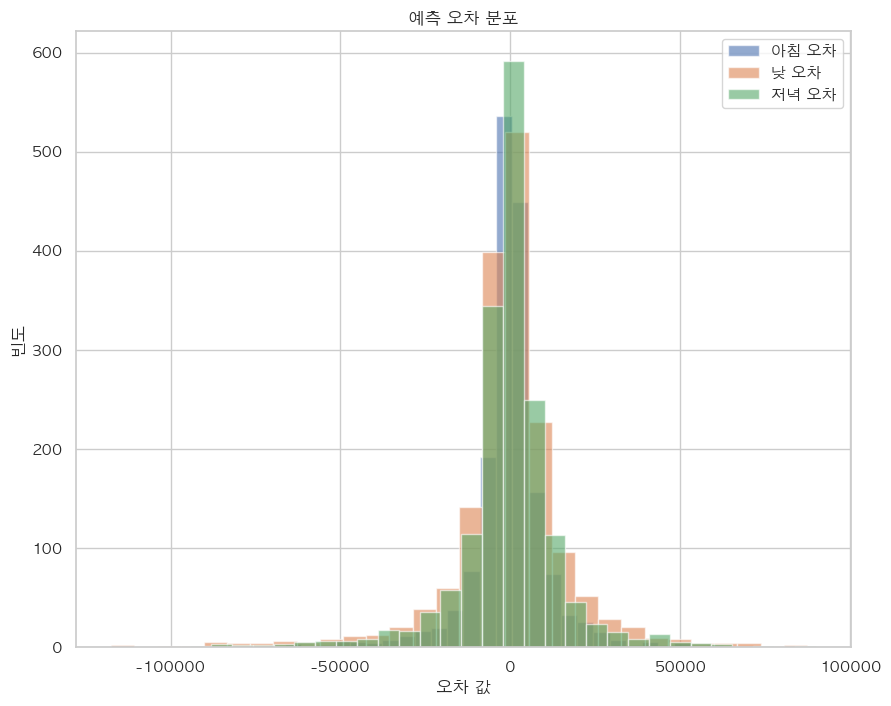

In [ ]:
# 오차 분포 히스토그램
time_periods = ['아침', '낮', '저녁']
errors = y_test_gb_usage - predicted_gb_usage
plt.figure(figsize=(10, 8))
for idx, time in enumerate(time_periods):
    plt.hist(errors.iloc[:, idx], bins=30, alpha=0.6, label=f'{time} 오차')
plt.xlabel('오차 값')
plt.ylabel('빈도')
plt.title('예측 오차 분포')
plt.legend()
plt.show()

> 회귀선에 점들이 모여있고, 오차분포 그래프가 0에 가까운 것이 많기 때문에 모델이 전반적으로 잘 동작하는 것을 알 수 있다.

## 시간대별 주차대수 예측 모델

### 데이터 준비

### 주차대수 예측 모델 학습 및 하이퍼파라미터 튜닝

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

# 교차 검증 및 하이퍼파라미터 튜닝 결과 저장
kf = KFold(n_splits=5, shuffle=True, )
gb_train_scores = []  # Fold별 훈련 점수
gb_test_scores = []   # Fold별 테스트 점수

# 그라디언트 부스팅 모델 초기 설정
gb_parking_model = MultiOutputRegressor(GradientBoostingRegressor())

for train_index, test_index in kf.split(X_train_gb_parking):
    # Fold별 데이터 분리
    X_train_fold, X_test_fold = X_train_gb_parking.iloc[train_index], X_train_gb_parking.iloc[test_index]
    y_train_fold, y_test_fold = y_train_gb_parking.iloc[train_index], y_train_gb_parking.iloc[test_index]
    
    # Fold별 모델 학습
    gb_parking_model.fit(X_train_fold, y_train_fold)
    
    # 점수 계산
    gb_train_scores.append(gb_parking_model.score(X_train_fold, y_train_fold))
    gb_test_scores.append(gb_parking_model.score(X_test_fold, y_test_fold))

# 하이퍼파라미터 튜닝 설정
param_grid_gb_parking = {
    'estimator__n_estimators': [100, 200, 300, 400, 500],
    'estimator__learning_rate': [0.05, 0.1, 0.2],
    'estimator__max_depth': [3, 5, 7],
}

# MultiOutputRegressor를 사용한 GridSearchCV
gb_multi_model = MultiOutputRegressor(GradientBoostingRegressor(random_state=42))
grid_search_parking = GridSearchCV(
    gb_multi_model,
    param_grid_gb_parking,# 하이퍼파라미터
    scoring='r2', # R2 점수출력
    cv=3, # 3-Fold 교차 검증
    n_jobs=-1, # 병렬 처리
    return_train_score=True
)

# 모델 학습 및 최적 하이퍼파라미터 찾기
grid_search_parking.fit(X_train_gb_parking, y_train_gb_parking)

# 최적 하이퍼파라미터 및 점수 출력
gb_best_params = grid_search_parking.best_params_
gb_best_score = grid_search_parking.best_score_

print("최적 하이퍼파라미터:", gb_best_params)
print("최고 R² 점수 (교차 검증):", gb_best_score)

최적 하이퍼파라미터: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 7, 'estimator__n_estimators': 300}
최고 R² 점수 (교차 검증): 0.8594211564885706


In [ ]:
# 교차 검증 결과 저장
results = pd.DataFrame(grid_search_parking.cv_results_)

### 최적 모델로 테스터 데이터 예측

In [ ]:
# 최적 모델로 테스트 데이터 예측
gb_final_parking_model = grid_search_parking.best_estimator_
gb_predicted_parking = gb_final_parking_model.predict(X_test_gb_parking)

# 훈련 및 테스트 데이터에서 모델 성능 평가
train_score_parking = gb_final_parking_model.score(X_train_gb_parking, y_train_gb_parking)
test_score_parking = gb_final_parking_model.score(X_test_gb_parking, y_test_gb_parking)

print(f"훈련 점수 (R²): {train_score_parking:.2f}")
print(f"테스트 점수 (R²): {test_score_parking:.2f}")

훈련 점수 (R²): 0.99
테스트 점수 (R²): 0.86


### 실제값 예측값

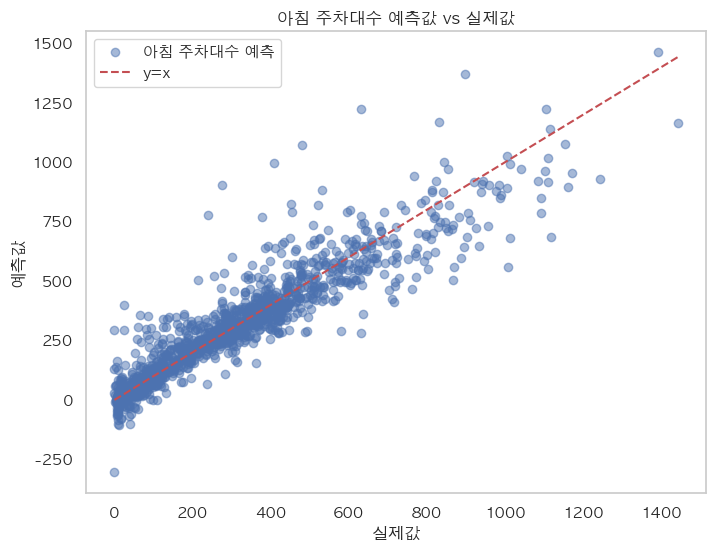

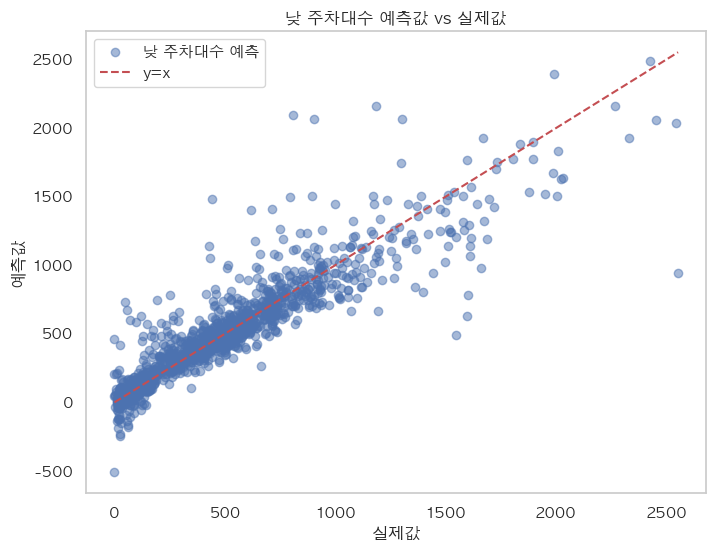

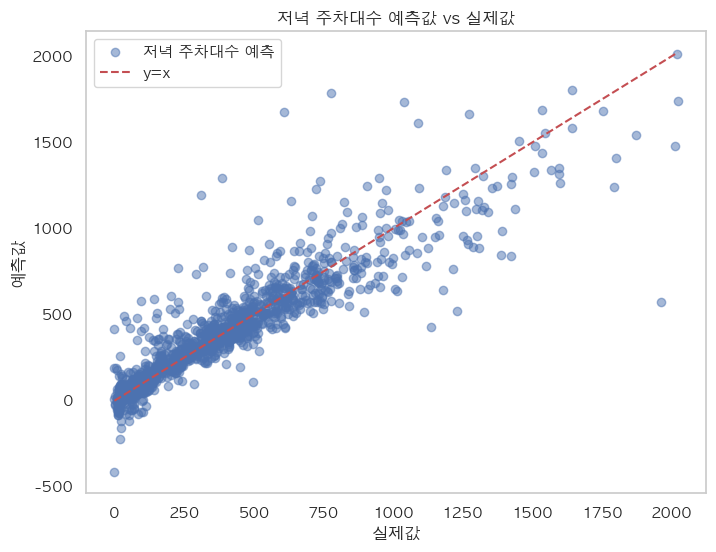

In [ ]:
# 예측값 vs 실제값 비교 (주차대수)
time_periods_parking = ['아침 주차대수', '낮 주차대수', '저녁 주차대수']

for idx, time in enumerate(time_periods_parking):
    plt.figure(figsize=(8, 6))
    plt.scatter(
        y_test_gb_parking.iloc[:, idx], gb_predicted_parking[:, idx],
        alpha=0.5, label=f"{time} 예측"
    )
    plt.plot(
        [y_test_gb_parking.iloc[:, idx].min(), y_test_gb_parking.iloc[:, idx].max()],
        [y_test_gb_parking.iloc[:, idx].min(), y_test_gb_parking.iloc[:, idx].max()],
        'r--', label='y=x'
    )
    plt.xlabel('실제값')
    plt.ylabel('예측값')
    plt.title(f"{time} 예측값 vs 실제값")
    plt.legend()
    plt.grid()
    plt.show()

### 훈련점수와 테스트 점수 비교 그래프

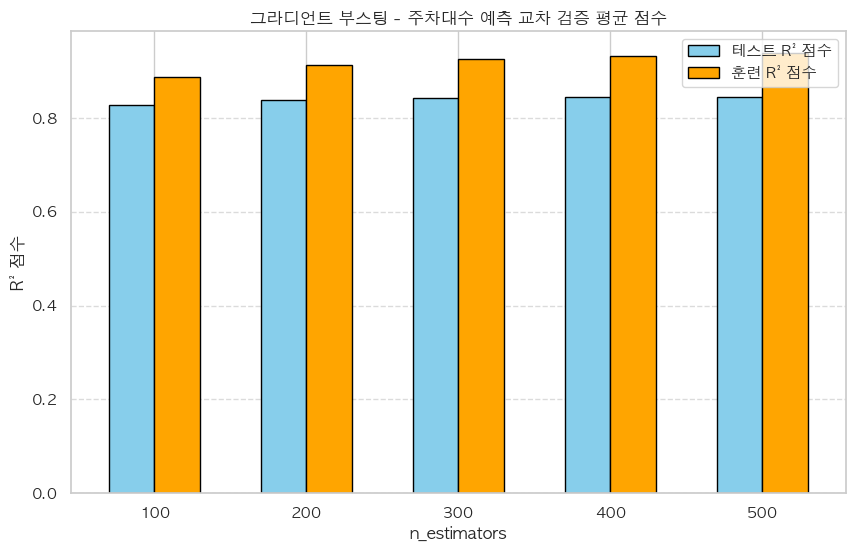

In [ ]:
import matplotlib.pyplot as plt

# n_estimators에 따른 평균 점수 계산
results['n_estimators'] = results['param_estimator__n_estimators'].astype(int)
grouped_scores = results.groupby('n_estimators')[['mean_test_score', 'mean_train_score']].mean()

# 막대그래프 그리기
grouped_scores.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange'], edgecolor='black', width=0.6)
plt.title('그라디언트 부스팅 - 주차대수 예측 교차 검증 평균 점수')
plt.xlabel('n_estimators')
plt.ylabel('R² 점수')
plt.xticks(rotation=0)
plt.legend(['테스트 R² 점수', '훈련 R² 점수'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 하이퍼파라미터 튜닝 시각화

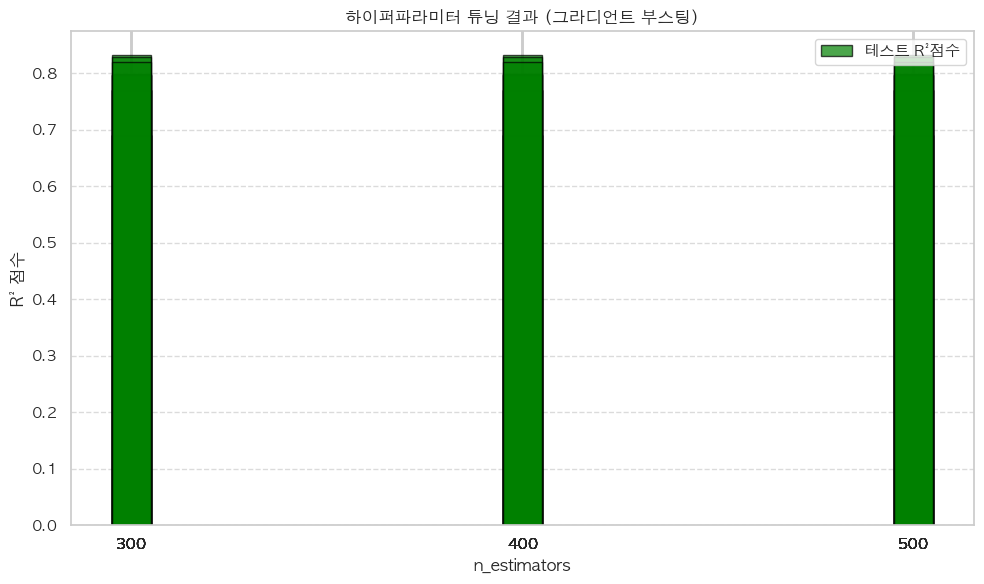

In [ ]:
# 하이퍼파라미터 튜닝 결과 시각화
param_values = [param['estimator__n_estimators'] for param in cv_results['params'] if 'estimator__n_estimators' in param]
mean_test_scores = cv_results['mean_test_score']

plt.figure(figsize=(10, 6))
plt.bar(param_values, mean_test_scores, color='green', edgecolor='black', alpha=0.7, label='테스트 R²점수', width=10)
plt.title('하이퍼파라미터 튜닝 결과 (그라디언트 부스팅)')
plt.xlabel('n_estimators')
plt.ylabel('R² 점수')
plt.xticks(param_values)  # x축 값 설정
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)  # y축에만 격자 추가
plt.tight_layout()  # 그래프 요소가 잘리거나 겹치지 않게 조정
plt.show()


### Fold별 교차 검증

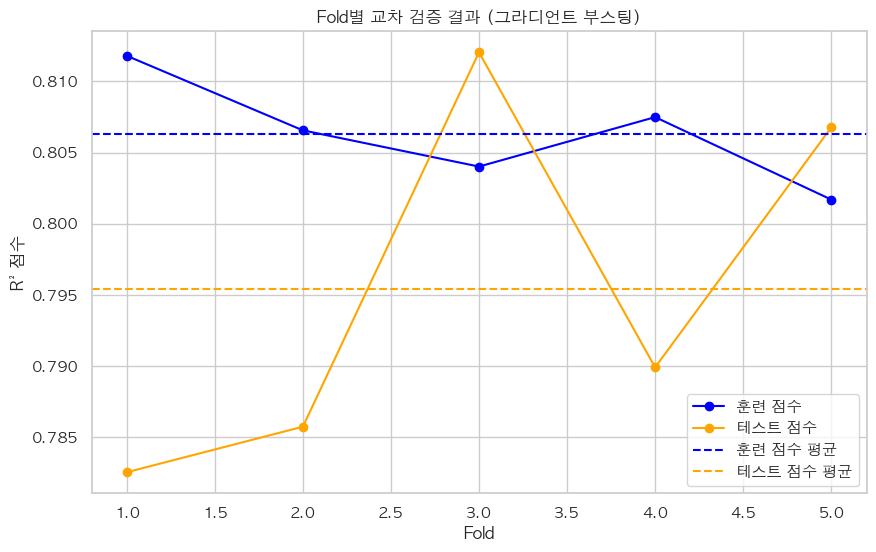

In [ ]:
# Fold별 교차 검증 점수 시각화
import matplotlib.pyplot as plt
import numpy as np

# Fold 개수
folds = range(1, len(gb_train_scores) + 1)

plt.figure(figsize=(10, 6))
plt.plot(folds, gb_train_scores, marker='o', label='훈련 점수', color='blue')
plt.plot(folds, gb_test_scores, marker='o', label='테스트 점수', color='orange')
plt.axhline(y=np.mean(gb_train_scores), color='blue', linestyle='--', label='훈련 점수 평균')
plt.axhline(y=np.mean(gb_test_scores), color='orange', linestyle='--', label='테스트 점수 평균')
plt.title('Fold별 교차 검증 결과 (그라디언트 부스팅)')
plt.xlabel('Fold')
plt.ylabel('R² 점수')
plt.legend()
plt.grid(True)
plt.show()

> Fold 2의 점수하락은 데이터 분포에 문제 가능성이 있을 것으로 추정되므로 추가 분석이 필요해보임.

### MAE와 MSE 시각화 코드

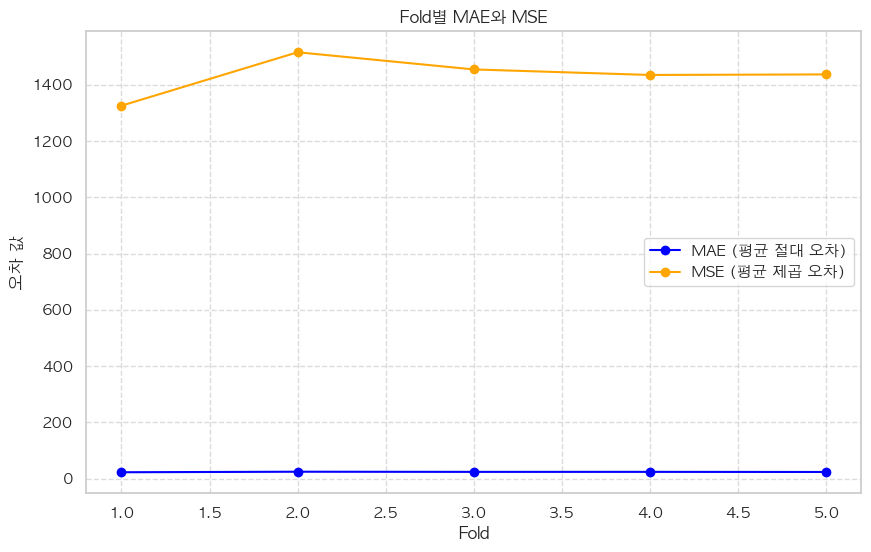

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# MAE와 MSE 저장 리스트
mae_scores = []
mse_scores = []

# KFold로 Fold별 데이터 분리 및 성능 계산
kf = KFold(n_splits=5, shuffle=True)

for train_index, test_index in kf.split(X_train_gb_parking):
    # Fold별 데이터 분리
    X_test_fold = X_train_gb_parking.iloc[test_index]
    y_test_fold = y_train_gb_parking.iloc[test_index]
    
    # 예측값 생성
    predictions = final_parking_model.predict(X_test_fold)
    
    # 실제값과 예측값 비교
    mae_scores.append(mean_absolute_error(y_test_fold, predictions))
    mse_scores.append(mean_squared_error(y_test_fold, predictions))

# Fold 번호 생성
folds = range(1, len(mae_scores) + 1)

# MAE와 MSE 시각화
plt.figure(figsize=(10, 6))
plt.plot(folds, mae_scores, marker='o', label='MAE (평균 절대 오차)', color='blue')
plt.plot(folds, mse_scores, marker='o', label='MSE (평균 제곱 오차)', color='orange')
plt.title('Fold별 MAE와 MSE')
plt.xlabel('Fold')
plt.ylabel('오차 값')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### 혼잡도 계산

In [ ]:
# 전체 데이터프레임에서 입력 피처 추출 (df_gb 기준)
X_full = pd.get_dummies(df_gb[features])

# 전체 데이터에 대해 예측
gb_predicted_parking_full = gb_final_parking_model.predict(X_full)

# 예측값을 데이터프레임에 추가
df_gb[['예측 아침 주차대수', '예측 낮 주차대수', '예측 저녁 주차대수']] = gb_predicted_parking_full

# 결과 확인
print(df_gb[['예측 아침 주차대수', '예측 낮 주차대수', '예측 저녁 주차대수']].head())

   예측 아침 주차대수    예측 낮 주차대수  예측 저녁 주차대수
0  461.760471   577.223914  515.851653
1  122.394115   153.550291  130.981633
2  705.696549   896.133359  801.386931
3  876.510343  1110.659550  997.435557
4   84.534069   115.737136   88.165314


In [ ]:
# 혼잡도 계산 함수
def calculate_congestion(parking_count, capacity):
    ratio = parking_count / capacity
    if ratio <= 0.5:
        return '여유'
    elif ratio <= 0.8:
        return '보통'
    elif ratio <= 1.0:
        return '혼잡'
    else:
        return '만차'

# 혼잡도 계산 및 데이터 추가
for time in ['아침', '낮', '저녁']:
    df_gb[f'예측 {time} 혼잡도'] = df_gb.apply(
        lambda row: calculate_congestion(row[f'예측 {time} 주차대수'], row['주차구획수']),
        axis=1
    )

# 최종 결과 데이터프레임
gb_final_result = df_gb[['날짜', '주차장명', '예측 아침 혼잡도', '예측 낮 혼잡도', '예측 저녁 혼잡도']]
print(gb_final_result.head())

          날짜     주차장명 예측 아침 혼잡도 예측 낮 혼잡도 예측 저녁 혼잡도
0 2024-09-30  여의도3주차장        보통       보통        보통
1 2024-09-30  여의도5주차장        혼잡       만차        혼잡
2 2024-09-30  여의도2주차장        만차       만차        만차
3 2024-09-30  여의도1주차장        만차       만차        만차
4 2024-09-30  여의도4주차장        여유       보통        여유


혼잡도              만차        보통        여유        혼잡
시간대                                              
예측 낮 혼잡도   0.157050  0.056598  0.090226  0.029459
예측 아침 혼잡도  0.104189  0.057856  0.144936  0.026352
예측 저녁 혼잡도  0.128496  0.054199  0.118230  0.032409


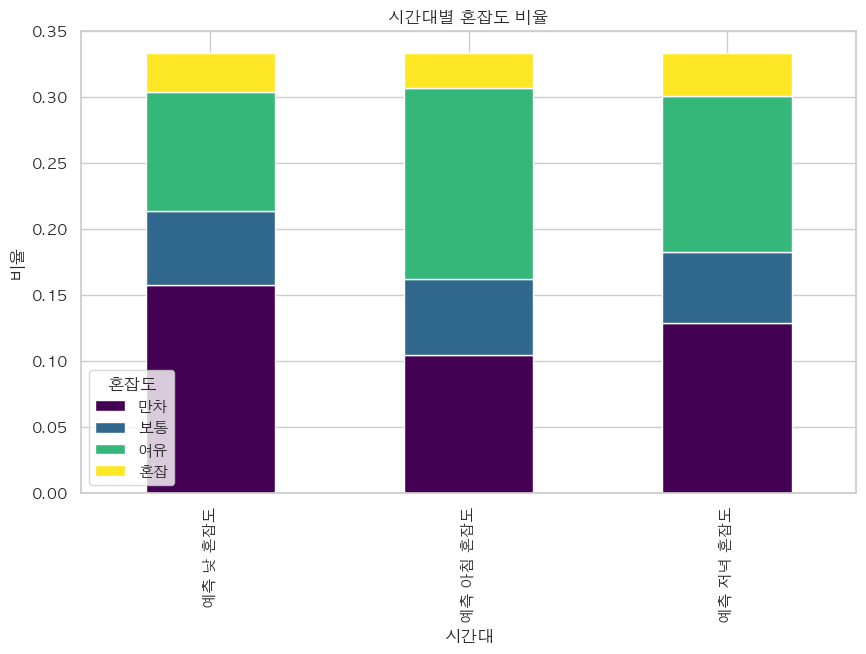

In [ ]:
# 시간대별 혼잡도 비율 계산
time_periods = ['예측 아침 혼잡도', '예측 낮 혼잡도', '예측 저녁 혼잡도']

# 혼잡도 값들을 집계하여 비율 계산
congestion_ratios = (
    df_gb[time_periods]
    .melt(var_name='시간대', value_name='혼잡도')
    .groupby(['시간대', '혼잡도'])
    .size()
    .unstack(fill_value=0)
    .div(df_gb[time_periods].count(axis=0).sum())
)
print(congestion_ratios)  # 비율 데이터 확인


# 시간대별 혼잡도 비율 그래프
congestion_ratios.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('시간대별 혼잡도 비율')
plt.xlabel('시간대')
plt.ylabel('비율')
plt.legend(title='혼잡도')
plt.show()

## XGBoost Regressor

### 이용시간 예측

### 하이퍼파라미터 튜닝 및 최적값 출력

In [ ]:
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV

# XGBoost 하이퍼파라미터 그리드 설정
param_grid_xgb = {
    'estimator__n_estimators': [100, 200, 300, 400, 500],
    'estimator__max_depth': [3, 5, 7],
    'estimator__learning_rate': [0.01, 0.1, 0.2],
    'estimator__subsample': [0.8, 1.0],
    'estimator__colsample_bytree': [0.8, 1.0]
}


# XGBoost 모델 설정
xgb_usage_model = MultiOutputRegressor(XGBRegressor())

# GridSearchCV 설정
grid_search_xgb = GridSearchCV(
    xgb_usage_model,
    param_grid_xgb,
    scoring='r2',
    cv=3,
    n_jobs=-1,
    return_train_score=True  # 훈련 점수 포함
)

# 학습 및 최적 파라미터 찾기
grid_search_xgb.fit(X_train_xgb_usage, y_train_xgb_usage)

# 최적 하이퍼파라미터 및 교차 검증 성능 출력
xgb_best_params = grid_search_xgb.best_params_
xgb_best_score = grid_search_xgb.best_score_

# 훈련 및 테스트 점수 계산
xgb_train_score = grid_search_xgb.score(X_train_xgb_usage, y_train_xgb_usage)  # 훈련 데이터 점수
xgb_test_score = grid_search_xgb.score(X_test_xgb_usage, y_test_xgb_usage)  # 테스트 데이터 점수

print("XGBoost 최적 하이퍼파라미터:", xgb_best_params)
print("XGBoost 최고 R² 점수 (교차 검증):", xgb_best_score)
print("XGBoost 훈련 R² 점수:", xgb_train_score)
print("XGBoost 테스트 R² 점수:", xgb_test_score)

XGBoost 최적 하이퍼파라미터: {'estimator__colsample_bytree': 0.8, 'estimator__learning_rate': 0.1, 'estimator__max_depth': 7, 'estimator__n_estimators': 400, 'estimator__subsample': 1.0}
XGBoost 최고 R² 점수 (교차 검증): 0.8652417467373265
XGBoost 훈련 R² 점수: 0.9822640419666961
XGBoost 테스트 R² 점수: 0.8758210980997833


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 최적 모델로 예측
best_xgb_model = grid_search_xgb.best_estimator_
predicted_xgb_usage = best_xgb_model.predict(X_test_xgb_usage)

# 평가 지표 계산
mse_xgb_usage = mean_squared_error(y_test_xgb_usage, predicted_xgb_usage)
mae_xgb_usage = mean_absolute_error(y_test_xgb_usage, predicted_xgb_usage)
r2_xgb_usage = r2_score(y_test_xgb_usage, predicted_xgb_usage)

# 결과 출력
print(f"최적 XGBoost 모델 평가 결과:")
print(f" - MSE: {mse_xgb_usage:.2f}")
print(f" - MAE: {mae_xgb_usage:.2f}")
print(f" - R²: {r2_xgb_usage:.2f}")

최적 XGBoost 모델 평가 결과:
 - MSE: 253688081.56
 - MAE: 9307.58
 - R²: 0.88


### 하이퍼파라미터 성능 시각화

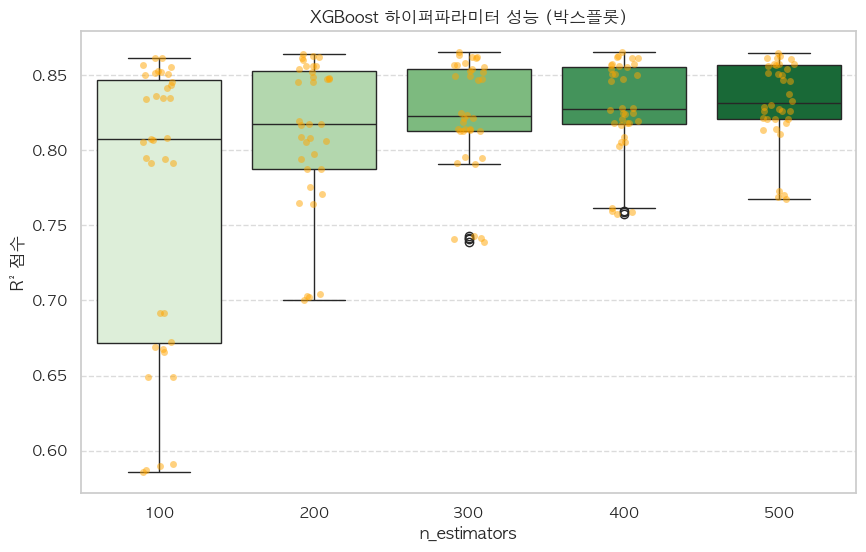

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# GridSearchCV 결과에서 데이터 추출
cv_results_xgb = pd.DataFrame(grid_search_xgb.cv_results_)  # GridSearchCV 결과

# `n_estimators` 별로 R² 점수를 추출
cv_results_xgb['n_estimators'] = cv_results_xgb['param_estimator__n_estimators']
cv_results_xgb['R2'] = cv_results_xgb['mean_test_score']

# 박스플롯 생성
plt.figure(figsize=(10, 6))
sns.boxplot(x='n_estimators', y='R2', data=cv_results_xgb, palette='Greens')  # 박스플롯
sns.stripplot(x='n_estimators', y='R2', data=cv_results_xgb, color='orange', alpha=0.5)  # 데이터 점 추가
plt.title('XGBoost 하이퍼파라미터 성능 (박스플롯)')
plt.xlabel('n_estimators')
plt.ylabel('R² 점수')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

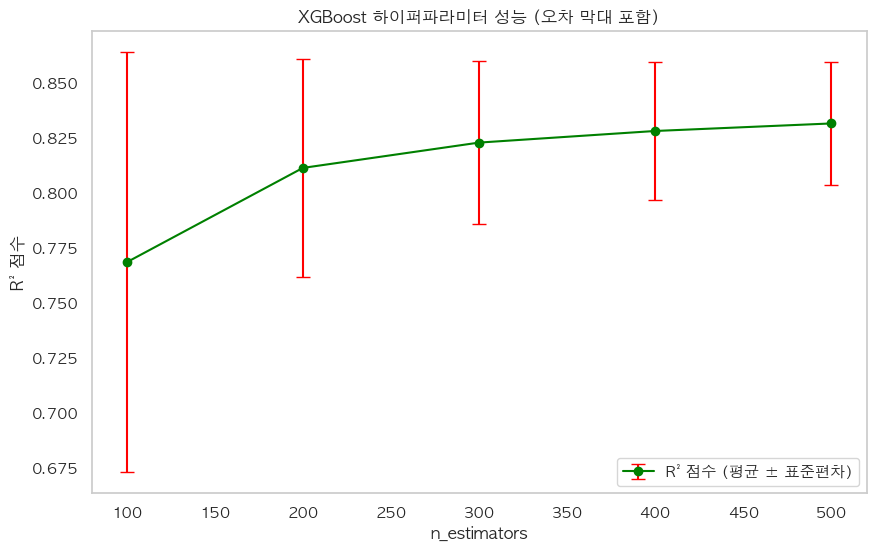

In [ ]:
# 평균 및 표준편차 계산
error_data_xgb = cv_results_xgb.groupby('param_estimator__n_estimators').agg(
    mean_R2=('mean_test_score', 'mean'),  # 평균 R² 점수
    std_R2=('mean_test_score', 'std')    # 표준편차 R² 점수
).reset_index()

plt.figure(figsize=(10, 6))
plt.errorbar(
    error_data_xgb['param_estimator__n_estimators'],  # n_estimators 값
    error_data_xgb['mean_R2'],                        # 평균 R² 점수
    yerr=error_data_xgb['std_R2'],                    # 표준편차 R² 점수
    fmt='-o',                                         # 선과 원형 마커 스타일
    capsize=5,                                        # 오차 막대 끝 점
    color='green',                                    # 선 색상
    ecolor='red',                                     # 오차 막대 색상
    label='R² 점수 (평균 ± 표준편차)'                 # 범례
)
plt.title('XGBoost 하이퍼파라미터 성능 (오차 막대 포함)')
plt.xlabel('n_estimators')
plt.ylabel('R² 점수')
plt.legend()
plt.grid()
plt.show()

> $R^2$ 점수가 n_estimators 500에서 가장 좋은 것을 확인할 수 있다.

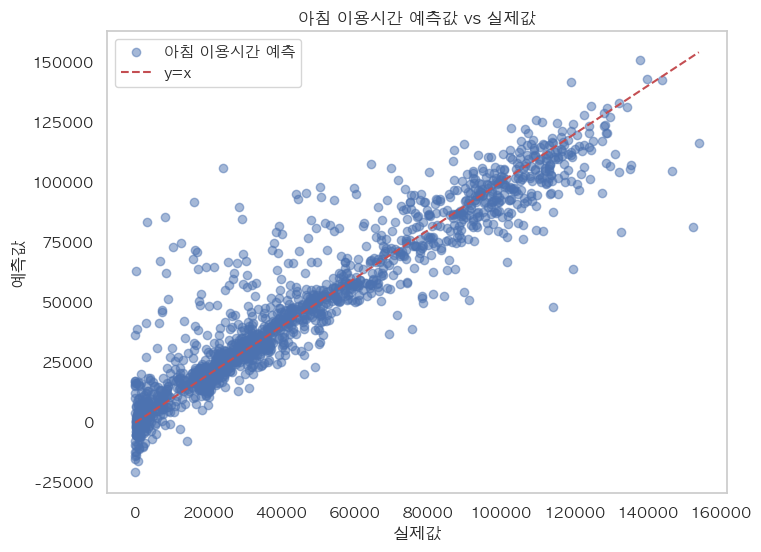

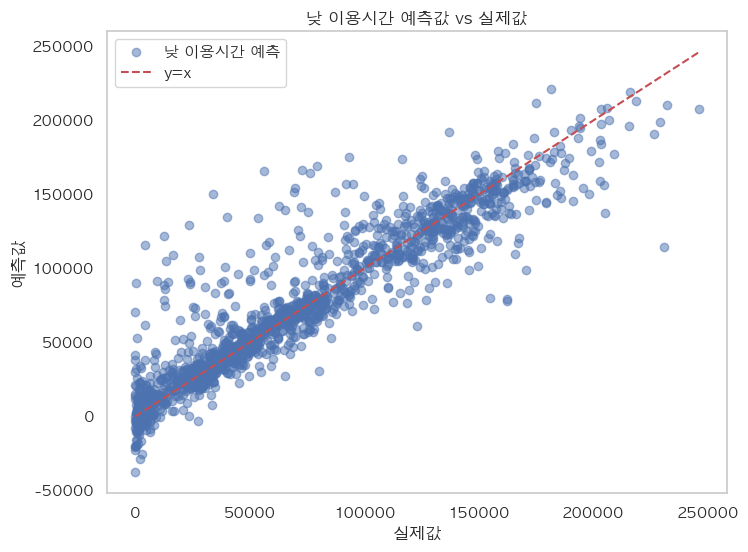

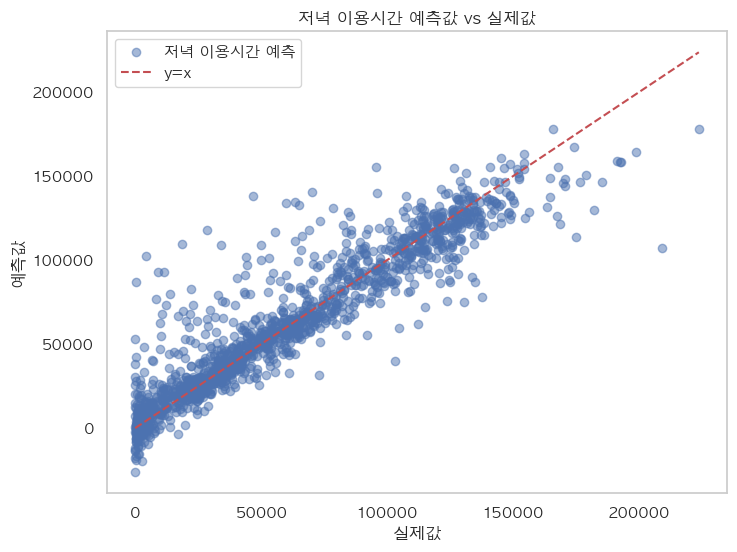

In [ ]:
# 예측값 vs 실제값 비교
time_periods = ['아침 이용시간', '낮 이용시간', '저녁 이용시간']

for idx, time in enumerate(time_periods):
    plt.figure(figsize=(8, 6))
    plt.scatter(
        y_test_xgb_usage.iloc[:, idx], predicted_xgb_usage[:, idx],
        alpha=0.5, label=f"{time} 예측"
    )
    plt.plot(
        [y_test_xgb_usage.iloc[:, idx].min(), y_test_xgb_usage.iloc[:, idx].max()],
        [y_test_xgb_usage.iloc[:, idx].min(), y_test_xgb_usage.iloc[:, idx].max()],
        'r--', label='y=x'
    )
    plt.xlabel('실제값')
    plt.ylabel('예측값')
    plt.title(f"{time} 예측값 vs 실제값")
    plt.legend()
    plt.grid()
    plt.show()

### 오차 분포 그래프

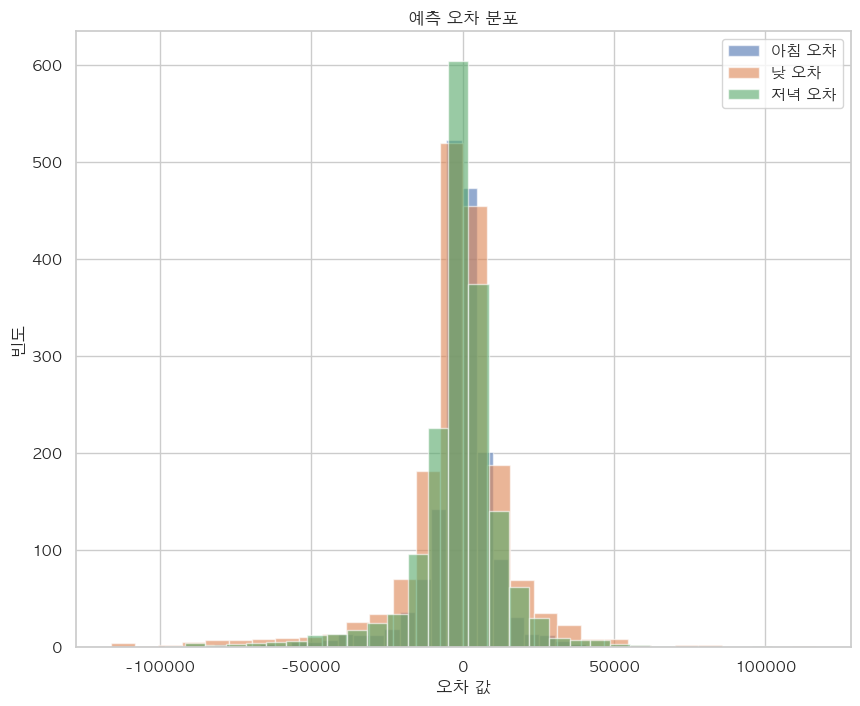

In [ ]:
# 오차 분포 히스토그램
time_periods = ['아침', '낮', '저녁']
errors = y_test_xgb_usage - predicted_xgb_usage
plt.figure(figsize=(10, 8))
for idx, time in enumerate(time_periods):
    plt.hist(errors.iloc[:, idx], bins=30, alpha=0.6, label=f'{time} 오차')
plt.xlabel('오차 값')
plt.ylabel('빈도')
plt.title('예측 오차 분포')
plt.legend()
plt.show()

> 회귀선에 점들이 모여있고, 오차분포 그래프가 0에 가까운 것이 많기 때문에 모델이 전반적으로 잘 동작하는 것을 알 수 있다.

## 시간대별 주차대수 예측 모델

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

# 교차 검증 및 하이퍼파라미터 튜닝 결과 저장
kf = KFold(n_splits=5, shuffle=True)
xgb_train_scores = []  # Fold별 훈련 점수
xgb_test_scores = []   # Fold별 테스트 점수

# XGBoost 모델 초기 설정
xgb_parking_model = XGBRegressor(n_estimators=100, eval_metric='rmse')

for train_index, test_index in kf.split(X_train_xgb_parking):
    # Fold별 데이터 분리
    X_train_fold, X_test_fold = X_train_xgb_parking.iloc[train_index], X_train_xgb_parking.iloc[test_index]
    y_train_fold, y_test_fold = y_train_xgb_parking.iloc[train_index], y_train_xgb_parking.iloc[test_index]
    
    # Fold별 모델 학습
    xgb_parking_model.fit(X_train_fold, y_train_fold)
    
    # 점수 계산
    xgb_train_scores.append(xgb_parking_model.score(X_train_fold, y_train_fold))
    xgb_test_scores.append(xgb_parking_model.score(X_test_fold, y_test_fold))

# 하이퍼파라미터 튜닝 설정
param_grid_xgb_parking = {
    'estimator__n_estimators': [100, 200, 300, 400, 500],
    'estimator__max_depth': [3, 6, 9],
    'estimator__learning_rate': [0.01, 0.1, 0.2],
    'estimator__subsample': [0.8, 1.0]
}

# MultiOutputRegressor를 사용한 GridSearchCV
xgb_multi_model = MultiOutputRegressor(XGBRegressor(random_state=42, eval_metric='rmse'))
grid_search_parking = GridSearchCV(
    xgb_multi_model,
    param_grid_xgb_parking,  # 하이퍼파라미터
    scoring='r2',  # R² 점수 출력
    cv=3,  # 3-Fold 교차 검증
    n_jobs=-1,  # 병렬 처리
    return_train_score=True
)

# 모델 학습 및 최적 하이퍼파라미터 찾기
grid_search_parking.fit(X_train_xgb_parking, y_train_xgb_parking)

# 최적 하이퍼파라미터 및 점수 출력
xgb_best_params = grid_search_parking.best_params_
xgb_best_score = grid_search_parking.best_score_

print("최적 하이퍼파라미터:", xgb_best_params)
print("최고 R² 점수 (교차 검증):", xgb_best_score)


최적 하이퍼파라미터: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 6, 'estimator__n_estimators': 300, 'estimator__subsample': 1.0}
최고 R² 점수 (교차 검증): 0.8498185826219831


In [ ]:
# 교차 검증 결과 저장
xgb_results = pd.DataFrame(grid_search_parking.cv_results_)

### 최적 모델로 테스터 데이터 예측

In [ ]:
# 최적 모델로 테스트 데이터 예측
xgb_final_parking_model = grid_search_parking.best_estimator_
xgb_predicted_parking = xgb_final_parking_model.predict(X_test_xgb_parking)

# 훈련 및 테스트 데이터에서 모델 성능 평가
train_score_parking = xgb_final_parking_model.score(X_train_xgb_parking, y_train_xgb_parking)
test_score_parking = xgb_final_parking_model.score(X_test_xgb_parking, y_test_xgb_parking)

print(f"훈련 점수 (R²): {train_score_parking:.2f}")
print(f"테스트 점수 (R²): {test_score_parking:.2f}")

훈련 점수 (R²): 0.96
테스트 점수 (R²): 0.88


### 실제값 예측값

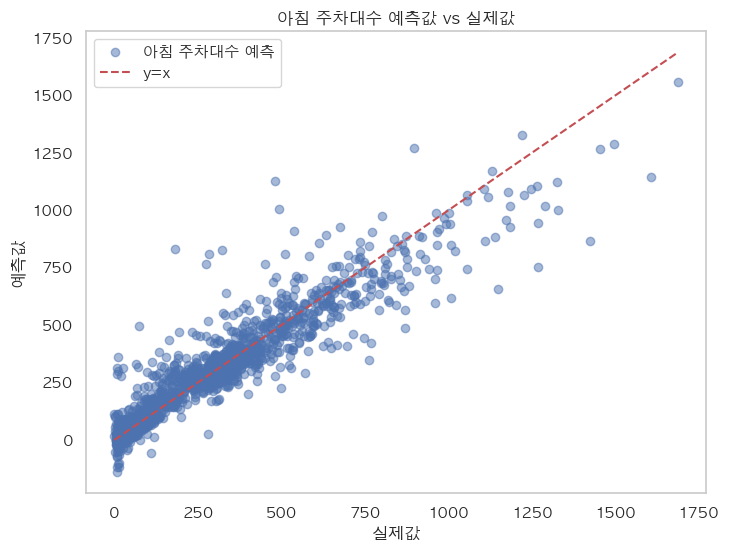

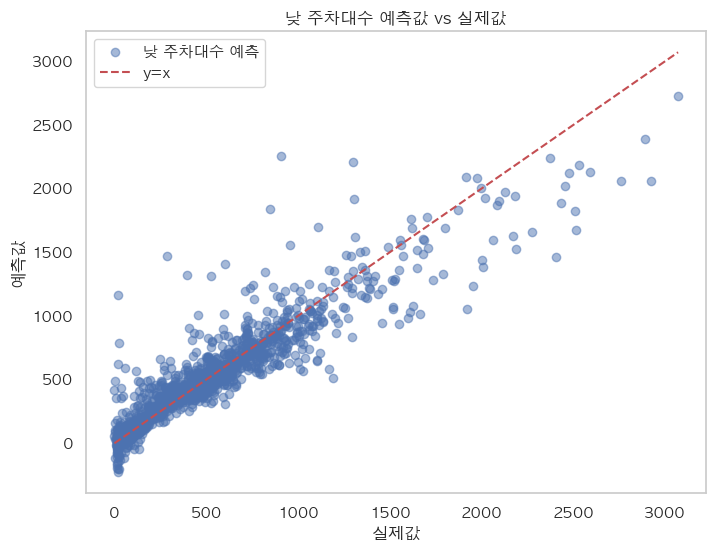

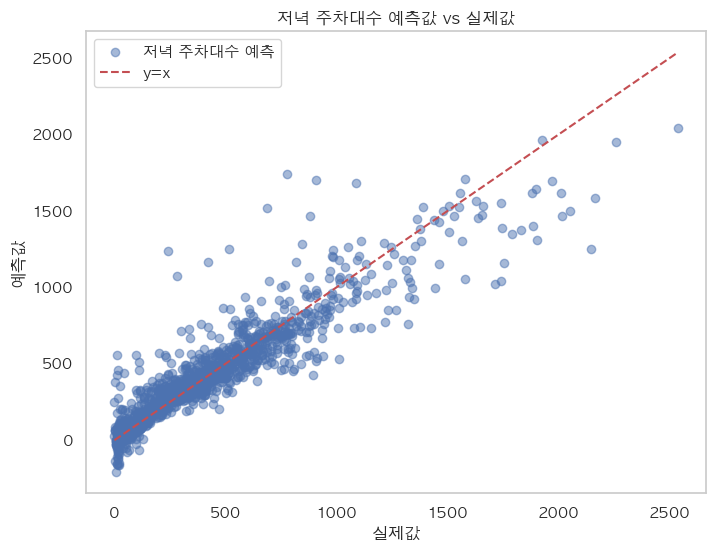

In [ ]:
# 예측값 vs 실제값 비교 (주차대수)
time_periods_parking = ['아침 주차대수', '낮 주차대수', '저녁 주차대수']

for idx, time in enumerate(time_periods_parking):
    plt.figure(figsize=(8, 6))
    plt.scatter(
        y_test_xgb_parking.iloc[:, idx], xgb_predicted_parking[:, idx],
        alpha=0.5, label=f"{time} 예측"
    )
    plt.plot(
        [y_test_xgb_parking.iloc[:, idx].min(), y_test_xgb_parking.iloc[:, idx].max()],
        [y_test_xgb_parking.iloc[:, idx].min(), y_test_xgb_parking.iloc[:, idx].max()],
        'r--', label='y=x'
    )
    plt.xlabel('실제값')
    plt.ylabel('예측값')
    plt.title(f"{time} 예측값 vs 실제값")
    plt.legend()
    plt.grid()
    plt.show()

### 훈련점수와 테스트 점수 비교 그래프

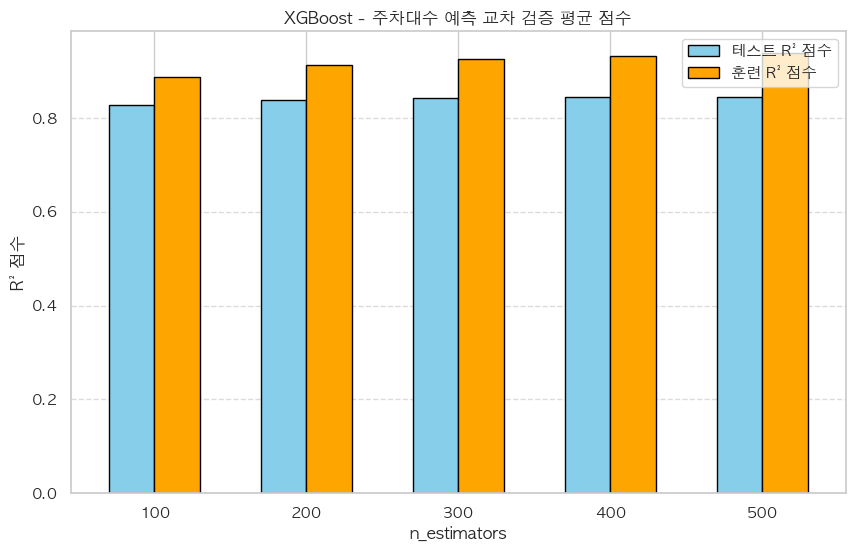

In [ ]:
import matplotlib.pyplot as plt

# n_estimators에 따른 평균 점수 계산
results['n_estimators'] = results['param_estimator__n_estimators'].astype(int)
grouped_scores = results.groupby('n_estimators')[['mean_test_score', 'mean_train_score']].mean()

# 막대그래프 그리기
grouped_scores.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange'], edgecolor='black', width=0.6)
plt.title('XGBoost - 주차대수 예측 교차 검증 평균 점수')
plt.xlabel('n_estimators')
plt.ylabel('R² 점수')
plt.xticks(rotation=0)
plt.legend(['테스트 R² 점수', '훈련 R² 점수'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 하이퍼파라미터 튜닝 시각화

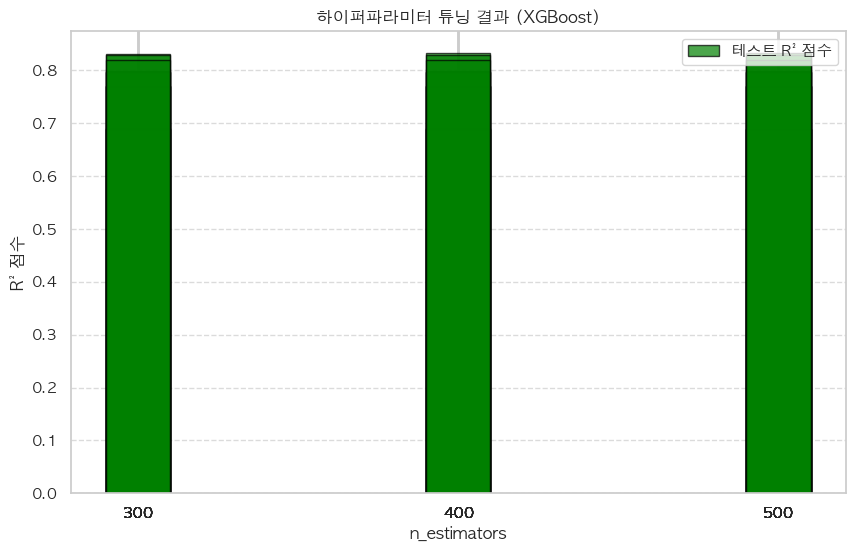

In [ ]:
# 하이퍼파라미터 튜닝 결과 시각화
param_values = [param['estimator__n_estimators'] for param in cv_results['params'] if 'estimator__n_estimators' in param]
mean_test_scores = cv_results['mean_test_score']

plt.figure(figsize=(10, 6))
plt.bar(param_values, mean_test_scores, color='green', edgecolor='black', alpha=0.7, label='테스트 R² 점수', width=20)
plt.title('하이퍼파라미터 튜닝 결과 (XGBoost)')
plt.xlabel('n_estimators')
plt.ylabel('R² 점수')
plt.xticks(param_values)  # x축 값 설정
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)  # y축에만 격자 추가
plt.show()

### Fold별 교차 검증

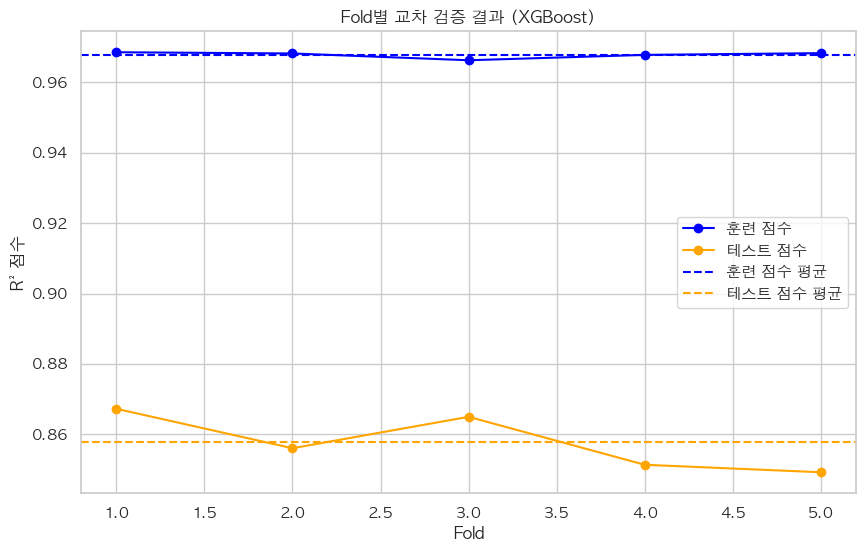

In [ ]:
# Fold별 교차 검증 점수 시각화
import matplotlib.pyplot as plt
import numpy as np

# Fold 개수
folds = range(1, len(xgb_train_scores) + 1)

plt.figure(figsize=(10, 6))
plt.plot(folds, xgb_train_scores, marker='o', label='훈련 점수', color='blue')
plt.plot(folds, xgb_test_scores, marker='o', label='테스트 점수', color='orange')
plt.axhline(y=np.mean(xgb_train_scores), color='blue', linestyle='--', label='훈련 점수 평균')
plt.axhline(y=np.mean(xgb_test_scores), color='orange', linestyle='--', label='테스트 점수 평균')
plt.title('Fold별 교차 검증 결과 (XGBoost)')
plt.xlabel('Fold')
plt.ylabel('R² 점수')
plt.legend()
plt.grid(True)
plt.show()

### MAE와 MSE 시각화 코드

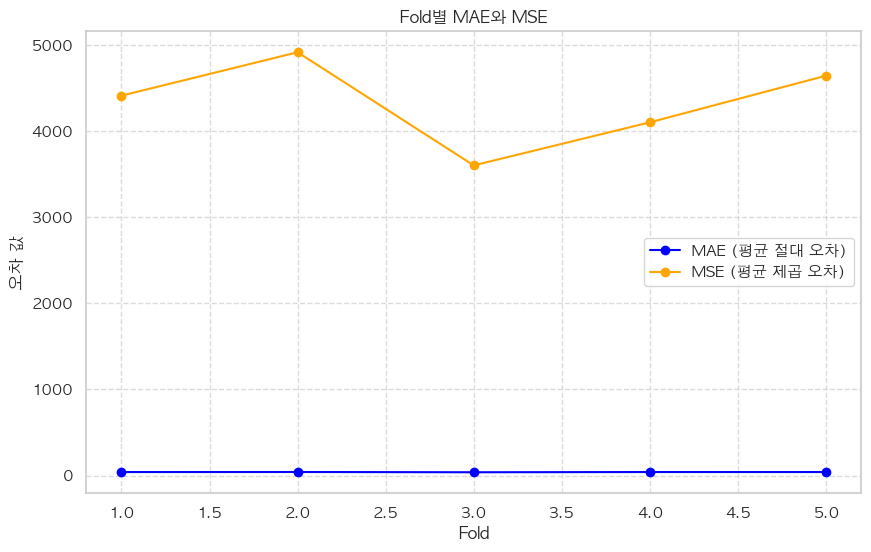

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# MAE와 MSE 저장 리스트
mae_scores = []
mse_scores = []

# KFold로 Fold별 데이터 분리 및 성능 계산
kf = KFold(n_splits=5, shuffle=True)

for train_index, test_index in kf.split(X_train_xgb_parking):
    # Fold별 데이터 분리
    X_test_fold = X_train_xgb_parking.iloc[test_index]
    y_test_fold = y_train_xgb_parking.iloc[test_index]
    
    # 예측값 생성
    predictions = xgb_final_parking_model.predict(X_test_fold)
    
    # 실제값과 예측값 비교
    mae_scores.append(mean_absolute_error(y_test_fold, predictions))
    mse_scores.append(mean_squared_error(y_test_fold, predictions))

# Fold 번호 생성
folds = range(1, len(mae_scores) + 1)

# MAE와 MSE 시각화
plt.figure(figsize=(10, 6))
plt.plot(folds, mae_scores, marker='o', label='MAE (평균 절대 오차)', color='blue')
plt.plot(folds, mse_scores, marker='o', label='MSE (평균 제곱 오차)', color='orange')
plt.title('Fold별 MAE와 MSE')
plt.xlabel('Fold')
plt.ylabel('오차 값')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

> MAE 값은 오차의 평균값으로 낮은 오차값을 가지며 정확히 예측한 것을 알 수 있다.    
  MSE 값은 오차의 평균 제곱값으로 첫 번째 Fold에서는 매우 높지만 이후 Fold에서 낮아지는 경향을 보입니다.      
  Fold는 1에서 불안정했으나 이후 안정화되었으므로 Fold 5가 최적의 평가 기준이 될 것으로 보임

### 혼잡도 계산

In [ ]:
# 전체 데이터프레임에서 입력 피처 추출 (df_gb 기준)
X_full = pd.get_dummies(df_xgb[features])

# 전체 데이터에 대해 예측
xgb_predicted_parking_full = xgb_final_parking_model.predict(X_full)

# 예측값을 데이터프레임에 추가
df_xgb[['예측 아침 주차대수', '예측 낮 주차대수', '예측 저녁 주차대수']] = xgb_predicted_parking_full

# 결과 확인
print(df_xgb[['예측 아침 주차대수', '예측 낮 주차대수', '예측 저녁 주차대수']].head())

   예측 아침 주차대수    예측 낮 주차대수  예측 저녁 주차대수
0  453.158569   603.653381  514.272766
1  136.654144   152.973358  146.383270
2  705.008850   913.231506  816.360840
3  824.966980  1048.718994  928.244141
4   76.325203    91.244514   86.541771


In [ ]:
df

지구별     주차장명  주차대수    이용시간         날짜  주차구획수    연도  월   일  요일  휴일여부  \
0     PLT-008  여의도3주차장  1558  407428 2024-09-30    785  2024  9  30   0     0   
1     PLT-008  여의도5주차장   377  102587 2024-09-30    141  2024  9  30   0     0   
2     PLT-008  여의도2주차장  2381  201372 2024-09-30    176  2024  9  30   0     0   
3     PLT-008  여의도1주차장  3041  450979 2024-09-30    462  2024  9  30   0     0   
4     PLT-008  여의도4주차장   203   69947 2024-09-30    218  2024  9  30   0     0   
...       ...      ...   ...     ...        ...    ...   ... ..  ..  ..   ...   
8470  PLT-008  여의도1주차장  1541  172802 2020-01-18    462  2020  1  18   5     1   
8471  PLT-008  여의도1주차장  1113  255747 2020-01-17    462  2020  1  17   4     0   
8472  PLT-008  여의도1주차장   873  221484 2020-01-16    462  2020  1  16   3     0   
8473  PLT-008  여의도1주차장   114    6073 2020-01-15    462  2020  1  15   2     0   
8474  PLT-008  여의도1주차장     2       0 2020-01-14    462  2020  1  14   1     0   

      아침 주차대수   낮 주차대수  저녁 주차대수        아침 이용시간         낮 이용시간        저녁 이용시간  
0      458.58   580.34   519.08  119921.907728  151763.007394  135743.084878  
1      110.96   140.43   125.61   30193.775915   38212.977215   34180.246870  
2      700.81   886.91   793.28   59270.689341   75010.012818   67091.297841  
3      895.08  1132.75  1013.17  132739.981361  167986.340760  150252.677879  
4       59.75    75.62    67.63   20587.848522   26056.118916   23303.032562  
...       ...      ...      ...            ...            ...            ...  
8470   354.57   654.68   531.75   39760.159079   73413.376613   59628.464309  
8471   299.44   441.87   371.69   68805.823612  101533.627035   85407.549353  
8472   238.22   348.38   286.41   60436.785925   88384.549914   72662.664162  
8473    30.55    46.38    37.07    1627.457456    2470.752105    1974.790439  
8474     0.53     0.82     0.65       0.000000       0.000000       0.000000  

[8475 rows x 17 columns]

In [ ]:
# 혼잡도 계산 함수
def calculate_congestion(parking_count, capacity):
    ratio = parking_count / capacity
    if ratio <= 0.5:
        return '여유'
    elif ratio <= 0.8:
        return '보통'
    elif ratio <= 1.0:
        return '혼잡'
    else:
        return '만차'

# 혼잡도 계산 및 데이터 추가
for time in ['아침', '낮', '저녁']:
    df_xgb[f'예측 {time} 혼잡도'] = df_xgb.apply(
        lambda row: calculate_congestion(row[f'예측 {time} 주차대수'], row['주차구획수']),
        axis=1
    )

# 최종 결과 데이터프레임
xgb_final_result = df_xgb[['날짜', '주차장명', '예측 아침 혼잡도', '예측 낮 혼잡도', '예측 저녁 혼잡도']]
print(xgb_final_result.head())

          날짜     주차장명 예측 아침 혼잡도 예측 낮 혼잡도 예측 저녁 혼잡도
0 2024-09-30  여의도3주차장        보통       보통        보통
1 2024-09-30  여의도5주차장        혼잡       만차        만차
2 2024-09-30  여의도2주차장        만차       만차        만차
3 2024-09-30  여의도1주차장        만차       만차        만차
4 2024-09-30  여의도4주차장        여유       여유        여유


### 혼잡도 분포 그래프

혼잡도              만차        보통        여유        혼잡
시간대                                              
예측 낮 혼잡도   0.157994  0.061396  0.085113  0.028830
예측 아침 혼잡도  0.106470  0.057463  0.143245  0.026155
예측 저녁 혼잡도  0.130580  0.056244  0.115044  0.031465


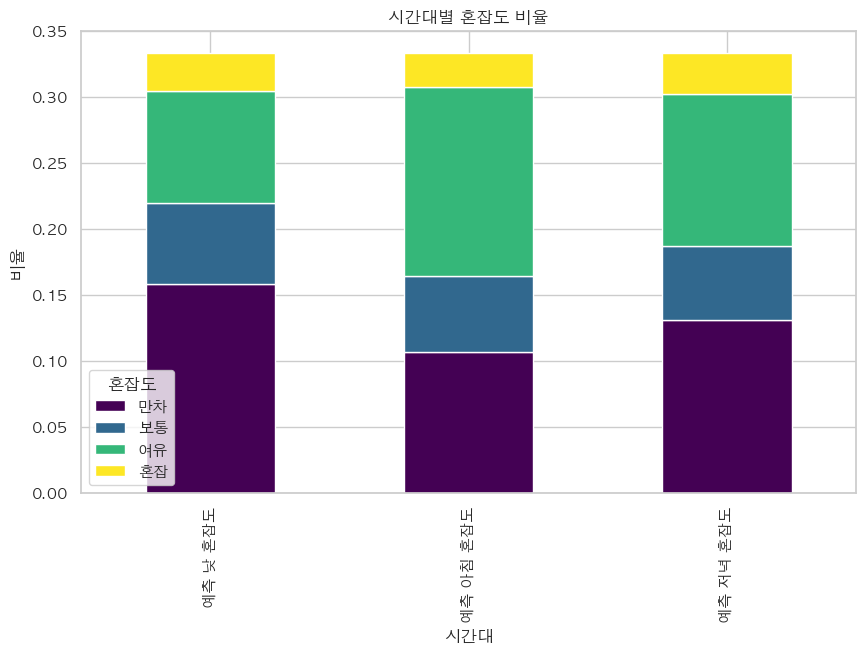

In [ ]:
# 시간대별 혼잡도 비율 계산
time_periods = ['예측 아침 혼잡도', '예측 낮 혼잡도', '예측 저녁 혼잡도']

# 혼잡도 값들을 집계하여 비율 계산
congestion_ratios = (
    df_xgb[time_periods]
    .melt(var_name='시간대', value_name='혼잡도')
    .groupby(['시간대', '혼잡도'])
    .size()
    .unstack(fill_value=0)
    .div(df_xgb[time_periods].count(axis=0).sum())
)
print(congestion_ratios)  # 비율 데이터 확인


# 시간대별 혼잡도 비율 그래프
congestion_ratios.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('시간대별 혼잡도 비율')
plt.xlabel('시간대')
plt.ylabel('비율')
plt.legend(title='혼잡도')
plt.show()

# 결론

### $R^2$ 값 비교

In [ ]:
models_performance = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting', 'XGBoost'],
    'Train R²': [rf_train_scores, gb_train_scores, xgb_train_scores],
    'Test R²': [rf_test_scores, gb_test_scores, xgb_test_scores]
})
print(models_performance)

# 테스트 R² 기준으로 정렬
sorted_models = models_performance.sort_values(by='Test R²', ascending=False)
print(sorted_models)

               Model                                           Train R²  \
0      Random Forest  [0.9753692509017586, 0.9751929421795668, 0.976...   
1  Gradient Boosting  [0.8117945385917221, 0.8065585261864475, 0.804...   
2            XGBoost  [0.9685770465897029, 0.9682310156854473, 0.966...   

                                             Test R²  
0  [0.838634817385106, 0.8527125796135157, 0.8506...  
1  [0.7825531058880119, 0.785750657177978, 0.8120...  
2  [0.8672429849871147, 0.8560348935316949, 0.864...  
               Model                                           Train R²  \
2            XGBoost  [0.9685770465897029, 0.9682310156854473, 0.966...   
0      Random Forest  [0.9753692509017586, 0.9751929421795668, 0.976...   
1  Gradient Boosting  [0.8117945385917221, 0.8065585261864475, 0.804...   

                                             Test R²  
2  [0.8672429849871147, 0.8560348935316949, 0.864...  
0  [0.838634817385106, 0.8527125796135157, 0.8506...  
1  [0.7825531

### MAE, MSE 비교

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# MAE와 MSE 계산
rf_mae = mean_absolute_error(y_test_rf_parking, rf_predicted_parking)
gb_mae = mean_absolute_error(y_test_gb_parking, gb_predicted_parking)
xgb_mae = mean_absolute_error(y_test_xgb_parking, xgb_predicted_parking)

rf_mse = mean_squared_error(y_test_rf_parking, rf_predicted_parking)
gb_mse = mean_squared_error(y_test_gb_parking, gb_predicted_parking)
xgb_mse = mean_squared_error(y_test_xgb_parking, xgb_predicted_parking)

# 결과 저장
error_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting', 'XGBoost'],
    'MAE': [rf_mae, gb_mae, xgb_mae],
    'MSE': [rf_mse, gb_mse, xgb_mse]
})
print(error_comparison)

# MAE와 MSE 기준으로 낮은 순서 정렬
sorted_errors = error_comparison.sort_values(by='MAE', ascending=True)
print(sorted_errors)

               Model        MAE           MSE
0      Random Forest  68.906744  20547.918882
1  Gradient Boosting  64.865245  14971.084992
2            XGBoost  68.752789  16031.696711
               Model        MAE           MSE
1  Gradient Boosting  64.865245  14971.084992
2            XGBoost  68.752789  16031.696711
0      Random Forest  68.906744  20547.918882


### 그래프 시각화

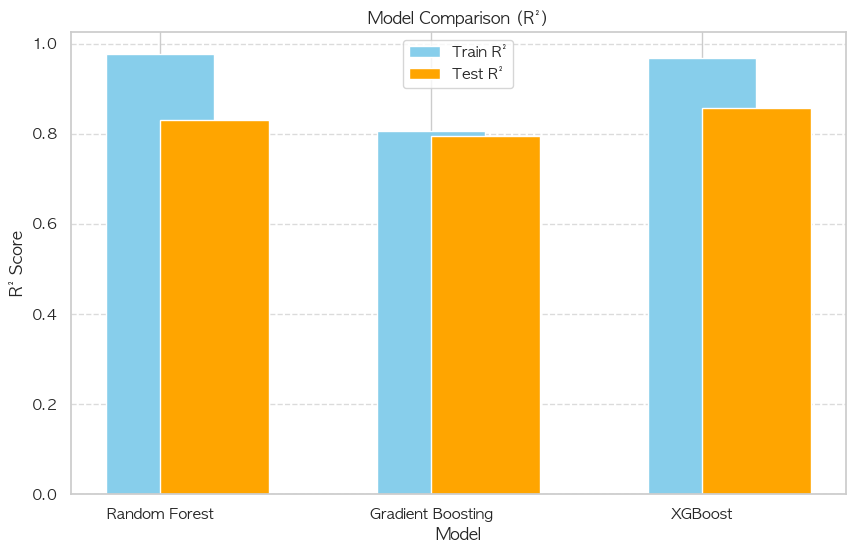

In [ ]:
import matplotlib.pyplot as plt

# R² 값 그래프
models = ['Random Forest', 'Gradient Boosting', 'XGBoost']
train_scores = [np.mean(rf_train_scores), np.mean(gb_train_scores), np.mean(xgb_train_scores)]
test_scores = [np.mean(rf_test_scores), np.mean(gb_test_scores), np.mean(xgb_test_scores)]

x = range(len(models))
plt.figure(figsize=(10, 6))
plt.bar(x, train_scores, width=0.4, label='Train R²', align='center', color='skyblue')
plt.bar(x, test_scores, width=0.4, label='Test R²', align='edge', color='orange')
plt.xticks(x, models)
plt.xlabel('Model')
plt.ylabel('R² Score')
plt.title('Model Comparison (R²)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

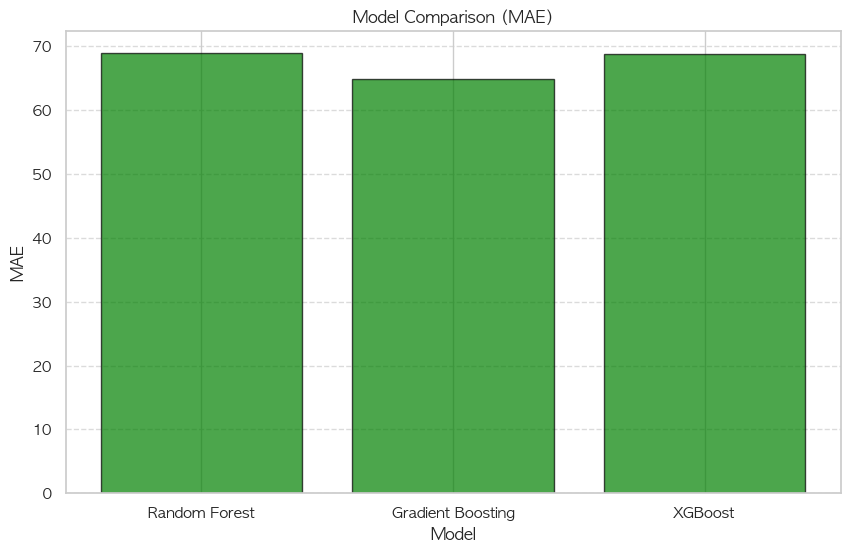

In [ ]:
# MAE 값 그래프
models = ['Random Forest', 'Gradient Boosting', 'XGBoost']
mae_scores = [rf_mae, gb_mae, xgb_mae]

plt.figure(figsize=(10, 6))
plt.bar(models, mae_scores, color='green', edgecolor='black', alpha=0.7)
plt.xlabel('Model')
plt.ylabel('MAE')
plt.title('Model Comparison (MAE)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 결론 도출
- $R^2$가 높으면서 MAE와 MSE가 낮은 모델을 선택
- 선택 기준
    1. $R^2$ : 테스트 $R^2$가 가장 높은 모델
    2. MAE/MSE: 가장 낮은 모델
    3. 훈련 $R^2$와 테스트 $R^2$의 차이가 크지 않은 모델(**과적합 방지**)

In [ ]:
sorted_models

Model                                           Train R²  \
2            XGBoost  [0.9685770465897029, 0.9682310156854473, 0.966...   
0      Random Forest  [0.9753692509017586, 0.9751929421795668, 0.976...   
1  Gradient Boosting  [0.8117945385917221, 0.8065585261864475, 0.804...   

                                             Test R²  
2  [0.8672429849871147, 0.8560348935316949, 0.864...  
0  [0.838634817385106, 0.8527125796135157, 0.8506...  
1  [0.7825531058880119, 0.785750657177978, 0.8120...

In [ ]:
# 모델 성능 정리
best_model = sorted_models.iloc[0]['Model']
print(f"최적의 모델은 {best_model} 입니다.")

최적의 모델은 XGBoost 입니다.


# 모델 저장
- 최종적으로 선정된 모델은 **XGBoost**입니다

## 주요 구성
**1. 데이터 준비:**
- 입력 피처와 타겟 변수로 데이터를 분리.
- pd.get_dummies()로 One-Hot Encoding 후 astype(float)로 데이터 타입 정리.
    
**2. 이용시간 예측:**
- XGBRegressor를 MultiOutputRegressor로 감싸 이용시간(아침,낮,저녁)을 예측.

**3. 주차대수 예측:**
- 이용시간 예측 결과를 입력 피처에 추가.
- 주차대수를 별도로 예측.

**4. 혼잡도 계산:**
- 예측된 주차대수를 기반으로 혼잡도 계산

**5. 파이프라인:**
- 입력 피쳐 -> 이용시간 예측 -> 주차대수 예측 -> 혼잡도 반환

**6. KFold:**               
##### KFold를 이용시간 예측에만 적용:
- 이용시간 모델 성능을 더 정밀하게 평가.
- 이용시간 예측 결과를 고정된 입력 데이터로 사용.
##### train_test_split을 주차대수 예측에 적용:
- 주차대수 모델은 이용시간 예측 결과를 입력으로 사용하므로, 추가적인 KFold가 필요하지 않음.

In [ ]:
import pandas as pd
import joblib
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split, KFold

# 1. 데이터 준비
features = ['요일', '휴일여부', '주차장명', '연도', '월', '일']
target_usage = ['아침 이용시간', '낮 이용시간', '저녁 이용시간']
targets_parking = ['아침 주차대수', '낮 주차대수', '저녁 주차대수']

# 범주형 데이터 원-핫 인코딩
X_xgb = pd.get_dummies(df[features])
y_xgb_usage = df[target_usage]
y_xgb_parking = df[targets_parking]

# 원-핫 인코딩 결과를 float 타입으로 변환
X_xgb = X_xgb.astype(float)

# 2. 이용시간 예측 모델 학습 (KFold)
kf = KFold(n_splits=5, shuffle=True)
usage_train_scores = []
usage_test_scores = []

for train_index, test_index in kf.split(X_xgb):
    X_train_usage, X_test_usage = X_xgb.iloc[train_index], X_xgb.iloc[test_index]
    y_train_usage, y_test_usage = y_xgb_usage.iloc[train_index], y_xgb_usage.iloc[test_index]

    # 이용시간 모델 학습
    usage_model = MultiOutputRegressor(
        XGBRegressor(learning_rate=0.1, max_depth=6, n_estimators=300)
    )
    usage_model.fit(X_train_usage, y_train_usage)

    # 점수 저장
    usage_train_scores.append(usage_model.score(X_train_usage, y_train_usage))
    usage_test_scores.append(usage_model.score(X_test_usage, y_test_usage))

# 평균 점수 출력
mean_usage_train_score = sum(usage_train_scores) / len(usage_train_scores)
mean_usage_test_score = sum(usage_test_scores) / len(usage_test_scores)
print(f"이용시간 모델 평균 훈련 점수 (R²): {mean_usage_train_score:.4f}")
print(f"이용시간 모델 평균 테스트 점수 (R²): {mean_usage_test_score:.4f}")

# 최종 이용시간 모델 학습 및 저장
usage_model.fit(X_xgb, y_xgb_usage)
joblib.dump(usage_model, 'xgb_usage_model.pkl')

# 예측된 이용시간 추가
df['예측 아침 이용시간'] = usage_model.predict(X_xgb)[:, 0]
df['예측 낮 이용시간'] = usage_model.predict(X_xgb)[:, 1]
df['예측 저녁 이용시간'] = usage_model.predict(X_xgb)[:, 2]

# 3. 주차대수 예측 모델 학습 (train_test_split)
# 주차대수 피처 구성
features_with_usage = ['예측 아침 이용시간', '예측 낮 이용시간', '예측 저녁 이용시간'] + features
X_parking = pd.get_dummies(df[features_with_usage])

# 데이터 분리 (train_test_split)
X_train_parking, X_test_parking, y_train_parking, y_test_parking = train_test_split(
    X_parking, y_xgb_parking, test_size=0.2
)

# 주차대수 모델 학습
parking_model = MultiOutputRegressor(
    XGBRegressor(learning_rate=0.1, max_depth=6, n_estimators=300)
)
parking_model.fit(X_train_parking, y_train_parking)

# 주차대수 모델 저장
joblib.dump(parking_model, 'xgb_parking_model.pkl')

# 훈련 및 테스트 성능 평가
train_score_parking = parking_model.score(X_train_parking, y_train_parking)
test_score_parking = parking_model.score(X_test_parking, y_test_parking)
print(f"주차대수 모델 훈련 점수 (R²): {train_score_parking:.4f}")
print(f"주차대수 모델 테스트 점수 (R²): {test_score_parking:.4f}")

# 4. 혼잡도 계산 함수 정의
def calculate_congestion(parking_count, capacity):
    ratio = parking_count / capacity
    if ratio <= 0.5:
        return '여유'
    elif ratio <= 0.8:
        return '보통'
    elif ratio <= 1.0:
        return '혼잡'
    else:
        return '만차'

# 전체 데이터에서 예측된 주차대수 계산
predicted_parking_full = parking_model.predict(X_parking)

# 혼잡도 계산 및 결과 추가
for time, idx in zip(['아침', '낮', '저녁'], range(3)):
    df[f'{time} 혼잡도'] = [
        calculate_congestion(p, c)
        for p, c in zip(predicted_parking_full[:, idx], df['주차구획수'])
    ]

# 최종 결과 출력
result = df[['주차장명', '아침 혼잡도', '낮 혼잡도', '저녁 혼잡도', '예측 아침 이용시간', '예측 낮 이용시간', '예측 저녁 이용시간']]
print(result.head())

이용시간 모델 평균 훈련 점수 (R²): 0.9570
이용시간 모델 평균 테스트 점수 (R²): 0.8750
주차대수 모델 훈련 점수 (R²): 0.9876
주차대수 모델 테스트 점수 (R²): 0.9264
      주차장명 아침 혼잡도 낮 혼잡도 저녁 혼잡도     예측 아침 이용시간      예측 낮 이용시간     예측 저녁 이용시간
0  여의도3주차장     보통    보통     보통  124671.609375  153756.343750  133833.578125
1  여의도5주차장     혼잡    만차     혼잡   37035.937500   45730.503906   41481.117188
2  여의도2주차장     만차    만차     만차   59392.890625   75643.445312   67583.890625
3  여의도1주차장     만차    만차     만차  120837.039062  145080.062500  139309.203125
4  여의도4주차장     여유    여유     여유   25348.291016   29988.367188   27485.166016
